# Python Competency Demo Code

Author: Albert Lee

Data: Mock data on web & store traffic and purchase for an e-commerce company

Date: 2024-05-20

---
### Initial Set up

Import necessary libraries and set up to get the local files into jupyter code

In [1]:
# import python libraries

import os 
import json

import datetime as dt
import pandas as pd
from decimal import Decimal
import duckdb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [2]:
# set up code to get the file saved in my local folder
dir = os.getcwd()
excel_file = '/Users/albertlee/repos/github/case/data.xlsx'

# really important to point out that web_events_item_brand.csv was modified to file below so that user_pseudo_id is parsed in two numbers using 'text to columns' feature in excel, and saved as this file
# python limitation where converting float or int to varchar loses accuracy and numbers on the last decimals bypassed
csv_file = '/Users/albertlee/repos/github/case/web_events_item_brand_mod.csv' 

file_path_excel = os.path.join(dir, excel_file)
file_path_csv = os.path.join(dir, csv_file)
tab_names = ['showroom_sales','store_traffic']

In [3]:
# create read_excel_sheet function to convert tabs named above under tab_names into two separate dataframes
def read_excel_sheets(file_path_excel):
    # load the xls file
    xls = pd.ExcelFile(file_path_excel)
    
    # create a dictionary to store DataFrames
    tab_df = {}
    
    # iterate for each sheet name
    for i in tab_names:
        # check if the sheet name is present in the file
        if i in xls.sheet_names:
            # read the sheet into a DataFrame
            df = pd.read_excel(xls, i)
            # store the DataFrame in dictionary
            tab_df[i] = df
        else:
            
            print(f"Warning: '{i}' not found in the Excel file.")
            
    return tab_df

# run the function and store into df value
dataframes = read_excel_sheets(file_path_excel)

In [4]:
# ensure dataframe view set up so that it's easy to read throughout the analysis
pd.set_option('display.max_columns', None)  # This shows all columns
pd.set_option('display.width', 1000)  # Adjusts the width of the display to prevent wrapping
pd.set_option('display.max_rows', 25)

In [5]:
# put each of the data tables provided into dataframes 
store_sales_df = dataframes['showroom_sales']
store_traffic_df = dataframes['store_traffic']
web_traffic_df = pd.read_csv(file_path_csv, low_memory=False)

---
### Data Cleanse

We must go ahead first to observe and clean the data before we begin the analysis

In [6]:
# START working on store_sales_df tab

# conver user_id into string format
store_sales_df['user_id'] = store_sales_df['user_id'].astype(str)

# convert DD/MM/YYYY to YYYY-MM-DD date format for data uniformity/consistency sake
store_sales_df['event_date_GMT'] = pd.to_datetime(store_sales_df['event_date'], format='%d/%m/%Y').dt.date

# convert Timestamp column to HH:MM:SS only and eradicate any unnecessary microsecond values to
## a) for data read easability sake
## b) to address inconsistencies in data detected on row 4 where the value did not have microseconds captured
store_sales_df['event_timestamp_GMT'] = store_sales_df['event_timestamp'].apply(lambda x: x.strftime('%H:%M:%S'))

# create event date & timestamp column so that it can be used for various ways
store_sales_df['event_timestamp_GMT'] = pd.to_datetime(store_sales_df['event_date_GMT'].astype(str) + ' ' + store_sales_df['event_timestamp_GMT'].astype(str))


In [7]:
# ASSUMPTION STATEMENT: upon observing the timestamp values, they all seem to be in UTC
# action: for the easibility, convert the event_date_stamp values from UTC to Singapore Local time (GMT+8)

store_sales_df['event_timestamp_GMT'] = store_sales_df['event_timestamp_GMT'].dt.tz_localize('UTC')                                                           
store_sales_df['event_timestamp_local'] = store_sales_df['event_timestamp_GMT'].dt.tz_convert('Etc/GMT-8')

# remove unnecessary strings after HH:MM:SS for timezone localization for both columns
store_sales_df['event_timestamp_GMT'] = store_sales_df['event_timestamp_GMT'].dt.tz_localize(None)
store_sales_df['event_timestamp_local'] = store_sales_df['event_timestamp_local'].dt.tz_localize(None)

# create a new column where based on event_date_timestamp_local's date, spit out day kind (Mo,Tu etc.)
store_sales_df['event_day_GMT'] = store_sales_df['event_timestamp_GMT'].dt.day_name().str[:3]
store_sales_df['event_day_local'] = store_sales_df['event_timestamp_local'].dt.day_name().str[:3]

# create a new column of event_date_local 
store_sales_df['event_date_GMT'] = store_sales_df['event_timestamp_GMT'].dt.date
store_sales_df['event_date_local'] = store_sales_df['event_timestamp_local'].dt.date

# create a new column of weekend vs. weekday definition based on the day of event_date_timestamp_local value
def define_day(day):
    if day == 'Sat' or day == 'Sun':
        return 'Weekend'
    else:
        return 'Weekday'

store_sales_df['event_day_kind_GMT'] = store_sales_df['event_day_GMT'].apply(define_day)
store_sales_df['event_day_kind_local'] = store_sales_df['event_day_local'].apply(define_day)

In [8]:
# reorganize the table

# rename first column that was blank to event_id
store_sales_df.rename(columns={'Unnamed: 0': 'event_id'}, inplace=True)
# Relevant event date and timestamp only
# store_sales_df.drop(['event_date], axis=1, inplace=True)
# reorganize the columns as explicitly said
store_sales_df = store_sales_df[['event_id','event_name','user_id','event_timestamp_GMT','event_timestamp_local'
                                 ,'event_date_GMT','event_date_local','event_day_GMT','event_day_local'
                                 ,'event_day_kind_GMT','event_day_kind_local','items']]

In [9]:
# create store_sales_details_df dataframe: expand items column that is JSON and create a new dataframe showroom_sales_details_df 

# need this since through observing the data 
# create function correct_json to convert single quotes to double quotes in the json string of items column
def correct_json(json_string):
    # replace single quotes with double quotes
    return json_string.replace("'", '"').replace("nan", "null")

# create a new DataFrame by expanding the JSON in each row of 'items'
# assuming showroom_sales_df is already loaded and structured
data = []
for index, row in store_sales_df.iterrows():
    try:
        # attempt to correct and then load the JSON data
        corrected_json = correct_json(row['items'])
        items = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Error processing JSON for row {index}: {e}")
        continue  # skip rows with invalid JSON data

    for item in items:
        data.append({
            'event_id': row['event_id'],
            'event_name': row['event_name'],
            'user_id': row['user_id'],
            'event_timestamp_GMT': row['event_timestamp_GMT'],
            'event_timestamp_local': row['event_timestamp_local'],
            'event_date_GMT': row['event_date_GMT'],
            'event_date_local': row['event_date_local'],
            'event_day_GMT': row['event_day_GMT'],
            'event_day_local': row['event_day_local'],
            'event_day_kind_GMT': row['event_day_kind_GMT'],
            'event_day_kind_local': row['event_day_kind_local'],
            'item_id': item['item_id'],
            'price': item['price'],
            'quantity': item['quantity']
        })

# convert the list of dictionaries to a DataFrame
store_sales_details_df = pd.DataFrame(data)

# sort the DataFrame by 'user_id' and 'event_date_timestamp'
store_sales_details_df = store_sales_details_df.sort_values(by=['user_id', 'event_timestamp_local'])

In [10]:
# END store sales dataframes -- now complete with cleanup
# store_traffic_df
# store_sales_df # 225 rows
# store_sales_details_df # 445 rows

In [11]:
# START work on web_traffic_df data

# let me standardize the data
# convert UNIX values of event_timestamp into two new columns of event_timestamp_local and event_date_local

# first unix in microseconds into regular timestamp 
web_traffic_df['event_timestamp_GMT'] = pd.to_datetime(web_traffic_df['event_timestamp'], unit='us')
web_traffic_df['event_timestamp_GMT'] = pd.to_datetime(web_traffic_df['event_timestamp_GMT'].dt.strftime('%Y-%m-%d %H:%M:%S'))

# localization of GMT and local Singapore time
web_traffic_df['event_timestamp_GMT'] = web_traffic_df['event_timestamp_GMT'].dt.tz_localize('UTC')                                                           
web_traffic_df['event_timestamp_local'] = web_traffic_df['event_timestamp_GMT'].dt.tz_convert('Etc/GMT-8')

# remove unnecessary strings after HH:MM:SS for timezone localization for both columns
web_traffic_df['event_timestamp_GMT'] = web_traffic_df['event_timestamp_GMT'].dt.tz_localize(None)
web_traffic_df['event_timestamp_local'] = web_traffic_df['event_timestamp_local'].dt.tz_localize(None)

# overwrite event_date with proper YYYY-MM-DD format
web_traffic_df['event_date_GMT'] = web_traffic_df['event_timestamp_GMT'].dt.date
# create event_date_local column
web_traffic_df['event_date_local'] = web_traffic_df['event_timestamp_local'].dt.date

# create a new column where based on event_date_timestamp_local's date, spit out day kind (Mo,Tu etc.)
web_traffic_df['event_day_GMT'] = web_traffic_df['event_timestamp_GMT'].dt.day_name().str[:3]
web_traffic_df['event_day_local'] = web_traffic_df['event_timestamp_local'].dt.day_name().str[:3]

# reuse define_day function i created earlier to get weekday vs. weekend data
web_traffic_df['event_day_kind_GMT'] = web_traffic_df['event_day_GMT'].apply(define_day)
web_traffic_df['event_day_kind_local'] = web_traffic_df['event_day_local'].apply(define_day)



In [12]:
# convert user_id and user_pseudo_id 
web_traffic_df['user_id'] = web_traffic_df['user_id'].fillna(-1)  # Using -1 or another impossible value as a placeholder
web_traffic_df['user_id'] = web_traffic_df['user_id'].astype(int)
web_traffic_df['user_id'] = web_traffic_df['user_id'].astype(str).replace('-1', 'NaN')

web_traffic_df['session_id'] = web_traffic_df['session_id'].astype(str)

web_traffic_df['user_pseudo_id1'] = web_traffic_df['user_pseudo_id1'].astype(str)
web_traffic_df['user_pseudo_id2'] = web_traffic_df['user_pseudo_id2'].astype(str)
# combine user_pseudo_id1 and user_pseudo_id2 to get the full user_pseudo_id that was not capable to bring over in full characters due to python limitations
web_traffic_df['user_pseudo_id'] = web_traffic_df['user_pseudo_id1'] + '.' + web_traffic_df['user_pseudo_id2'] 

In [13]:
# SUCCESS checkpoint -- keeping all of the decimals and thus the full character of user_pseudo_id -> 
# web_traffic_df[web_traffic_df['user_pseudo_id'] == '1305673156.1638157599']

In [14]:
# OBSERVATION STATEMENT: observing that event_date_local follows the event_date
# it is at this point, to have determined to use local time zone for date and time instead of GMT time zone for the entirety of the analysis

# web_traffic_df # 775248 rows

#print(web_traffic_df.sort_values(by=['session_id', 'user_pseudo_id','user_id','event_timestamp']))
#print(web_traffic_df.sort_values(by=['session_id', 'user_pseudo_id','user_id','event_date_timestamp_local']))

In [15]:
# reorganize data now

# ran below query to find that 'Unnamed: 0' have duplicates and must delete
## print(web_events_item_brand.sort_values(by='Unnamed: 0', ascending = True))

# delete first column, event_date and event_timestamp since it's not needed, so that the only date and time related data represents local Singapore Time only
web_traffic_df.drop(['Unnamed: 0','event_date', 'event_timestamp','user_pseudo_id1','user_pseudo_id2'], axis=1, inplace=True)

# rearrange the columns in a proper order that facilitates the reading of "session A of B event by user C occured on D date and time to have X items bought"
web_traffic_df = web_traffic_df[['session_id', 'event_name', 'user_id', 'user_pseudo_id', 
                    'event_date_GMT','event_date_local', 'event_timestamp_GMT', 'event_timestamp_local', 
                    'event_day_GMT','event_day_local', 'event_day_kind_GMT','event_day_kind_local', 
                    'items']]

In [16]:
# create web_traffic_details_df dataframe: expand items column that is JSON and create a new dataframe web_events_details_df

# but first isolate only the rows that have item column populated
web_traffic_details_temp = web_traffic_df[web_traffic_df['items'].notna()]

# reuse the correct_json function created earlier for this parsing
data = []
for index, row in web_traffic_details_temp.iterrows():
    try:
        # attempt to correct and then load the JSON data
        corrected_json = correct_json(row['items'])
        items = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Error processing JSON for row {index}: {e}")
        continue  # skip rows with 

    for item in items:
        data.append({
            'session_id': row['session_id'],
            'event_name': row['event_name'],
            'user_id': row['user_id'],
            'user_pseudo_id': row['user_pseudo_id'],
            'event_date_GMT': row['event_date_GMT'],
            'event_date_local': row['event_date_local'],
            'event_timestamp_GMT': row['event_timestamp_GMT'],
            'event_timestamp_local': row['event_timestamp_local'],
            'event_day_GMT': row['event_day_GMT'],
            'event_day_local': row['event_day_local'],
            'event_day_kind_GMT': row['event_day_kind_GMT'],
            'event_day_kind_local': row['event_day_kind_local'],
            'item_id': item['item_id'],
            'item_brand': item['item_brand'],
            'price': item['price'],
            'quantity': item['quantity']
        })

# convert the list of dictionaries to a DataFrame
web_traffic_details_df = pd.DataFrame(data)

# sort the DataFrame by 'user_id' and 'event_date_timestamp'
web_traffic_details_df = web_traffic_details_df.sort_values(by=['session_id', 'event_timestamp_local'])

In [17]:
# OBSERVATION STATEMENT: observing that there are anomalies found from 02-17 to 02-20 making data in these dates unusable - drop data to make dates uniformed

# absolutely no add to carts, checkouts and purchases from Known users from 2022-02-17 to 2020-02-20
# i suspect there's bug in the system and should not count these dates for analysis

# problem_web_data = """ 
# SELECT
#   case when user_id = 'NaN' THEN 'Unknown' ELSE 'Known' END as user_anonymity
#   ,event_date_local
#   ,event_name
#   ,COUNT(DISTINCT CONCAT(COALESCE(user_id,user_pseudo_id),session_id))
# FROM 
#   web_traffic_df
# WHERE event_date_local BETWEEN '2022-02-17' AND '2022-02-27'
#   --AND user_id = 'NaN'
# GROUP BY 1,2,3
# ORDER BY 2,1,3
# """

# duckdb.query(problem_web_data).df()

# it is at this point to realize that for all data, we should focus on 2022-02-17 to 2022-02-28

# work below to only keep the data from these date range per event_date_local
start_date = '2022-02-21'
end_date = '2022-02-27'

store_traffic_df = store_traffic_df[(store_traffic_df['date'] >= start_date) & (store_traffic_df['date'] <= end_date)]

store_sales_df['event_date_local'] = pd.to_datetime(store_sales_df['event_date_local'])
store_sales_df = store_sales_df[(store_sales_df['event_date_local'] >= start_date) & (store_sales_df['event_date_local'] <= end_date)]

store_sales_details_df['event_date_local'] = pd.to_datetime(store_sales_details_df['event_date_local'])
store_sales_details_df = store_sales_details_df[(store_sales_details_df['event_date_local'] >= start_date) & (store_sales_details_df['event_date_local'] <= end_date)]

web_traffic_df['event_date_local'] = pd.to_datetime(web_traffic_df['event_date_local'])
web_traffic_df = web_traffic_df[(web_traffic_df['event_date_local'] >= start_date) & (web_traffic_df['event_date_local'] <= end_date)]

web_traffic_details_df['event_date_local'] = pd.to_datetime(web_traffic_details_df['event_date_local'])
web_traffic_details_df = web_traffic_details_df[(web_traffic_details_df['event_date_local'] >= start_date) & (web_traffic_details_df['event_date_local'] <= end_date)]

/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/4077629276.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_sales_df['event_date_local'] = pd.to_datetime(store_sales_df['event_date_local'])


In [18]:
# SUCCESS checkpoint -- reduction in row counts and check of reductions for all dataframes thus far

# check the min and max dates to check the work
# print(web_traffic_details_df['event_date_local'].min()) # 2022-02-21 00:00:00
# print(web_traffic_details_df['event_date_local'].max()) # 2022-02-27 00:00:00

# reduction summary
# store_sales_df # 225 rows to 225 rows : no reduction
# store_sales_details_df # 455 rows to 455 rows : no reduction
# store_traffic_df # 11 rows to 7 rows : no reduction
# web_traffic_df # 775248 rows to 434035 rows : reduction of 341213 rows (roughly 44%)
# web_traffic_details_df # 21268 rows to 21268 rows : no reduction

In [19]:
# now we only work with data range from 2022-02-21 to 2022-02-27 for the entirety of the analysis -- easy and also uniformed also given it's Monday to Sunday (one week)

In [20]:
# OBSERVATION STATEMENT: there are suspected fraud activities captured within the dataset, and needs to be removed for cleaner analysis
## 1) capture list_1 that will have 3 user_pseudo_id to be removed for suspected fraud ... top 2 user_pseudo_id's that have the most num_user_id associated 75
## 2) capture list_2 that will have 48 user_psuedo_id to be removed for suspected fraud ... they have events where 3 or more different user_id's drove a single event_name at the same timestamp
## 3) capture unique user_pseudo_id's (48) and use this list to remove any rows that have this user on web_traffic_df and web_traffic_details_df

## ---------------- OBSERVATION NOTES: START ---------------- ##
# realized this a bit late on in the analysis but this user_pseudo_id seems to be a bot, having 56 checkout events of 28 different user_id's on 2022-02-21 10:07:08	local time
# web_traffic_details_df[
#     (web_traffic_details_df['user_pseudo_id'] == '1757366132.1637906940') &
#     (web_traffic_details_df['event_date_local'].between('2022-02-21', '2022-02-21'))
# ]

# found this user_pseudo_id 683308137.1642660180 with 1638 rows seemingly made up of duplicate entries
# web_traffic_df[web_traffic_df['user_pseudo_id'] == '683308137.1642660180']
# web_traffic_df[web_traffic_df['user_pseudo_id'] == '683308137.1642660180'].nunique()
# web_traffic_details_df[web_traffic_details_df['user_pseudo_id'] == web_traffic_details_df.groupby('user_pseudo_id')['user_id'].nunique().idxmax()]

# it is at this point we need to dig into something fishy

# web_traffic_df[(web_traffic_df['session_id'] == '1645409225') & (web_traffic_df['user_id'] == '93994')]

## ---------------- OBSERVATION NOTES: END ---------------- ##

In [21]:
# seek activity data that belong to problematic user_pseudo_id's and destroy data that belong to them in web_traffic_df and web_traffic_details_df dataframe

# --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- #
# Execute Start on 1) above 

users_potential_fraud_list_1 = """
WITH main AS ( 
  SELECT 
    user_pseudo_id,COUNT(user_id_key) as num_user_id_associated,SUM(num_pv),SUM(num_atc),SUM(num_checkout)
  FROM
    (
      SELECT *,
        CASE WHEN num_checkout > num_atc THEN 1 ELSE 0 END as flag
      FROM
      (
        SELECT 
          COALESCE(user_id,user_pseudo_id) as user_id_key
          ,user_pseudo_id
          ,session_id
          ,SUM(CASE WHEN event_name = 'page_view' THEN 1 ELSE 0 END) as num_pv
          ,SUM(CASE WHEN event_name = 'add_to_cart' THEN 1 ELSE 0 END) as num_atc
          ,SUM(CASE WHEN event_name = 'begin_checkout' THEN 1 ELSE 0 END) as num_checkout
          ,COUNT(DISTINCT user_id) as num_user_id
        FROM
          web_traffic_df
        GROUP BY 1,2,3
      )
      WHERE flag > 0
    )
  GROUP BY 1
  ORDER BY 3 DESC
)
SELECT a.*, b.num_time_activity_atc,c.num_time_activity_bc 
FROM main a
LEFT JOIN  
      (
      SELECT user_pseudo_id, COUNT(event_timestamp_local) as num_time_activity_atc FROM web_traffic_df 
      WHERE event_name = 'add_to_cart'
      GROUP BY 1
      ) b ON a.user_pseudo_id = b.user_pseudo_id
LEFT JOIN  
      (
      SELECT user_pseudo_id, COUNT(event_timestamp_local) as num_time_activity_bc FROM web_traffic_df 
      WHERE event_name = 'begin_checkout'
      GROUP BY 1
      ) c ON a.user_pseudo_id = c.user_pseudo_id
ORDER BY 2 DESC
LIMIT 3
"""
users_potential_fraud_list_1 = duckdb.query(users_potential_fraud_list_1).df()

# 3 user_pseudo_id to be removed for suspected fraud ... top 2 user_pseudo_id's that have the most num_user_id associated 75, 
# users_potential_fraud_list_1

# user_pseudo_id	          num_user_id_associated   sum(num_pv)   sum(num_atc)	sum(num_checkout)	num_time_activity_atc	  num_time_activity_bc
# 0	1454489573.1595907018	      75	                   525.0	        0.0	            75.0   	             3300	                       150
# 1	1757366132.1637906940	      56	                   420.0	       28.0	            84.0	                364	                       112
# 2	308505469.1640505016	      13	                  1768.0	       13.0	            26.0	                 65	                        26

# users_potential_fraud_list_2['user_pseudo_id'].nunique()

# Execute End on 1)
# --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- #

# Execute Start on 2) 

users_potential_fraud_list_2 = """
WITH main AS ( 
  SELECT 
    user_pseudo_id
    ,event_timestamp_local
    ,event_name
    ,COUNT(DISTINCT event_timestamp_local||user_id) as num_user_id
    ,MODE(event_timestamp_local) as datestamp_local_mode
  FROM
    web_traffic_df
  WHERE user_id != 'NaN' and user_id IS NOT NULL
  GROUP BY 1,2,3
  ORDER BY 4 DESC
)
SELECT user_pseudo_id,event_name,MAX(num_user_id),MODE(datestamp_local_mode) FROM main
GROUP BY 1,2
HAVING MAX(num_user_id)>=3
ORDER BY 3 DESC
LIMIT 150
"""

users_potential_fraud_list_2 = duckdb.query(users_potential_fraud_list_2).df()

# 48 user_psuedo_id to be removed for suspected fraud ... they have events where 3 or more different user_id's drove a single event_name at the same timestamp.
# users_potential_fraud_list_2

# Execute End on 2) 
# --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- #

# Execute Start on 3)

users_potential_fraud_list_1_unique = pd.DataFrame(users_potential_fraud_list_1['user_pseudo_id'].unique(), columns=['user_pseudo_id_unique'])

# unique values from column D of DataFrame C
users_potential_fraud_list_2_unique = pd.DataFrame(users_potential_fraud_list_2['user_pseudo_id'].unique(), columns=['user_pseudo_id_unique'])

# merge for unique values
merge_fraud_user_pseudo_id = users_potential_fraud_list_1_unique.merge(users_potential_fraud_list_2_unique, how='outer', left_on='user_pseudo_id_unique', right_on='user_pseudo_id_unique')
# merge_fraud_user_pseudo_id
# 48 unique user_pseudo_id

# execute the deletion!
web_traffic_df = web_traffic_df[~web_traffic_df['user_pseudo_id'].isin(merge_fraud_user_pseudo_id['user_pseudo_id_unique'])]
web_traffic_details_df = web_traffic_details_df[~web_traffic_details_df['user_pseudo_id'].isin(merge_fraud_user_pseudo_id['user_pseudo_id_unique'])]

# Execute Start on 3)
# --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- # --------------- #

In [22]:
# reduction summary
# store_sales_df # not affected
# store_sales_details_df # not affected
# store_traffic_df # not affected
# web_traffic_df # 434035 rows to 231417 rows : reduction of x rows (roughly 53% remain)
# web_traffic_details_df # 21268 rows to 2246 rows : reduction of x rows (roughly 11% remain)

##### Dataframes created so far: store_sales_df , store_sales_details_df , store_traffic_df , web_traffic_df , web_traffic_details_df 

In [23]:
# let's get store stats details per day first

pd.set_option('display.max_rows', 150)

store_stats_daily = """
WITH store_foot_traffic AS (
  SELECT date, "Offline Traffic" as num_store_visitors 
  FROM store_traffic_df
),
store_sales_traffic AS (
  SELECT event_date_local, event_day_local, event_day_kind_local ,COUNT(DISTINCT event_id) AS num_purchase_trans, COUNT(DISTINCT user_id) AS num_purchased_users, COUNT(item_id) AS num_purchase_items, SUM(price*quantity) AS rev
  FROM store_sales_details_df
  GROUP BY 1,2,3
  ORDER BY 1
)
SELECT 
  a.date as date_local
   ,b.event_day_kind_local as wkd_vs_wkn_local
   ,a.num_store_visitors as store_num_visitors
   ,b.num_purchase_trans as store_num_purchase_transactions
   ,b.num_purchased_users
   ,b.num_purchase_items as store_num_inventory_SKUs
   ,b.rev as store_sales_revenue
 FROM store_foot_traffic a
 LEFT JOIN store_sales_traffic b
   ON a.date = b.event_date_local
 ORDER BY 1

"""
store_stats_daily = duckdb.query(store_stats_daily).df()

# store_stats_daily.groupby('wkd_vs_wkn_local')['store_sales_revenue'].sum()
# print(store_stats_daily['store_sales_revenue'].sum())
store_stats_daily


,date_local,wkd_vs_wkn_local,store_num_visitors,store_num_purchase_transactions,num_purchased_users,store_num_inventory_SKUs,store_sales_revenue
0,2022-02-21,Weekday,33,23,22,42,27509.05
1,2022-02-22,Weekday,29,19,18,35,31399.21
2,2022-02-23,Weekday,35,24,24,51,41172.64
3,2022-02-24,Weekday,21,18,17,41,32852.40
4,2022-02-25,Weekday,34,21,19,44,31096.44
5,2022-02-26,Weekend,139,65,64,116,94023.24
6,2022-02-27,Weekend,93,55,55,126,107901.20


In [24]:
# Initial Notes on high-level online data needed per day and definitions

# first we want to get high level online data per day
# before we want to build the specifications on how we should determine each KPIs per day or any specific timeframe

# we also want to importantly limit the number of sessions to be only counted if the session duration is greater than or equal to 3 seconds
  # "3 seconds" can definitely be debated to be changed depending on the relevance threshold as a team.
  # this is to ensure that there isn't any non-meaningful sessions and its data being counted (specifically page views)

## number of sessions : totaled in aggregated per user session level*, time-bucketed per session start time
## number of page views : totaled in aggregate, time-bucketed per event time (at the moment of page view)
## number of add carts : totaled in aggregate per unique items value that is add cart event, per user session level*, time-bucketed per earliest add cart event in the session
## number of begin checkouts : totaled in aggregate per unique items value that is begin checkout event, per user session level*, time-bucketed per earliest begin_checkouts event in the session
## number of purchases : totaled in aggregate per unique items value per user session level*, time-bucketed per event time

## cart abandon sessions : sessions that have the add_cart as the most advanced state (after page views and add_cart, no checkout or purchase), time-bucketed per latest begin_checkout event in the session
## checkout abandons : sessions that have the begin_checkout as the most advanced state (after pageviews,add_cart, and checkout, no purchase), time-bucketed per latest begin_checkout event in the session

## session duration : difference between latest and earliest timestamp, measured per user session level*
## time from session start to first add cart : self-explanatory, measured per user session level*
## time from session start to purchase : self-explanatory, measured per user session level*
## time from first checkout to purchase : self-explanatory, measured per user session level*
## number of begin_checkout to purchase : self-explanatory, measured per user session level*

### user session level*: (a) per either user_id if it exists, or user_pseudo_id and b) additionally per session_id)

In [25]:
# OBSERVATION NOTES: user_id_key has to created to take in 'known' users (logged-in) vs. 'unknown' users (anonymized) ... cont'd

# we will use COALESCE function in SQL to create user_id_key to follow the logic where 
## a) for rows that have user_id != 'NaN' use user_id
## b) for remaining rows then user_pseudo_id (capturing those that are user_id = 'NaN') 

# sifting through the data, there are rows where ..
## a) user_id is blank but user_pseudo_id is not blank 
## # a) is expected : usually this is a traditional 'unknown' users where there is no log in of the users

# web_traffic_df[web_traffic_df['user_id'] == 'NaN']['event_name'].unique()
## # one thing to note about this population is that there is only page views attributed these rows, and unfortunately add_to_cart to purchase

## and 

## b) user_id and user_pseudo_id are both populated and 
## # b) however where it gets funky is that there are ...
## ## 1) one to many ID relationship between user_id to user_pseudo_id : is expected : expected traditionally where a user_id is a known user that logs in via multiple devices (which are captured per user_pseudo_id)
## ## 2) one to many ID relationship between user_pseudo_id to user_id : **is NOT expected : we removed some of these earlier in the data cleasing part

## and 

## c) one to many relationships can exist on session_id to user_id or user_pseudo_id
# web_traffic_df.groupby('session_id')['user_id'].nunique().sort_values(ascending=False)
# web_traffic_df[web_traffic_df['session_id'] == '1645779233'].sort_values('event_timestamp_local', ascending=False)
## it appears that the site tracking needs to be altered for best practices to ensure that if during a session, a logged in user logs off, and on the same device a different user_id logs in, that a different session_id is issued
## i would like to propose the company's site to have session_id issuance policy on a user_id to have one-to-one relationship


In [26]:
# create online_data_per_user_session dataframe table to get event level data that is shown on user_id and session_id level data

# observation on the data
# as written above, we will only include sessions that are 3 seconds or more in length. we will deem those that are 2, 1 or 0 seconds in total session length from start to finish to be irrelevant to the analysis

pd.set_option('display.max_rows', 100)
online_data_per_user_session = """
-- let's start ranking some of these events per user session level
WITH user_session_time_begin AS (
  SELECT 
    CASE WHEN user_id != 'NaN' THEN 'Known' WHEN user_id = 'NaN' THEN 'Unknown' ELSE 'Unknown' END as user_anonymity
    ,CASE WHEN user_id != 'NaN' THEN user_id WHEN user_id = 'NaN' THEN user_pseudo_id ELSE user_pseudo_id END as user_id_key
    ,session_id,event_name, event_date_local, event_timestamp_local,items
  FROM web_traffic_df
  ORDER BY user_id_key,event_timestamp_local
), 
user_session_step_one AS (
    SELECT
    user_anonymity,user_id_key,session_id
    -- metrics
    ,COUNT(DISTINCT CASE WHEN event_name = 'page_view' THEN event_timestamp_local ELSE NULL END) AS num_page_view
    ,COUNT(DISTINCT CASE WHEN event_name = 'add_to_cart' THEN items ELSE NULL END) AS num_add_to_cart
    ,COUNT(DISTINCT CASE WHEN event_name = 'begin_checkout' THEN items ELSE NULL END) AS num_begin_checkout
    ,COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN items ELSE NULL END) AS num_online_purchase
    ,MIN(event_timestamp_local) AS session_start_timestamp, MAX(event_timestamp_local) AS session_end_timestamp
  FROM 
    user_session_time_begin
  GROUP BY 1,2,3 
),
cart AS (
  SELECT 
    user_anonymity,user_id_key,session_id
    ,MIN(event_timestamp_local) AS first_add_cart_timestamp
    ,MAX(event_timestamp_local) AS last_add_cart_timestamp
  FROM user_session_time_begin 
  WHERE event_name = 'add_to_cart'
  GROUP BY 1,2,3
),
checkout AS (
  SELECT 
    user_anonymity,user_id_key,session_id
    ,MIN(event_timestamp_local) AS first_begin_checkout_timestamp
    ,MAX(event_timestamp_local) AS last_begin_checkout_timestamp 
  FROM user_session_time_begin 
  WHERE event_name = 'begin_checkout'
  GROUP BY 1,2,3
),
purchase AS (
  SELECT 
    user_anonymity,user_id_key,session_id
    ,MIN(event_timestamp_local) AS first_online_purchase_timestamp
  FROM user_session_time_begin 
  WHERE event_name = 'purchase'
  GROUP BY 1,2,3
),
rev AS (
  SELECT 
    'Known' as user_anonymity,user_id as user_id_key,session_id
    ,SUM(price*quantity) as online_sales_rev 
  FROM web_traffic_details_df 
  WHERE event_name = 'purchase' 
  GROUP BY 1,2,3
),

store_sales AS (
  SELECT
    'Known' as user_anonymity,user_id,event_id
    ,COUNT(DISTINCT event_id) AS num_store_purchase
    ,SUM(price*quantity) AS store_sales_rev
    ,SUM(CASE WHEN price > 0.00 THEN quantity ELSE 0 END) AS store_num_items_sold
    ,MIN(event_timestamp_local) AS earliest_store_purchase_time
  FROM
    store_sales_details_df
  GROUP BY 1,2,3
),

user_session_step_final AS (
  SELECT   
      a.user_anonymity,a.user_id_key, a.session_id
      -- metrics
      ,a.num_page_view
      ,a.num_add_to_cart
      ,a.num_begin_checkout
      ,a.num_online_purchase
      ,rev.online_sales_rev
      -- time
      ,a.session_start_timestamp, a.session_end_timestamp
      ,cart.first_add_cart_timestamp, cart.last_add_cart_timestamp 
      ,checkout.first_begin_checkout_timestamp, checkout.last_begin_checkout_timestamp
      ,purchase.first_online_purchase_timestamp
      -- durations
      ,CAST(session_end_timestamp - session_start_timestamp AS INTERVAL) AS session_duration
      ,CASE WHEN first_add_cart_timestamp IS NULL THEN NULL ELSE first_add_cart_timestamp - session_start_timestamp END AS session_start_to_first_add_cart_duration
      ,CASE WHEN first_begin_checkout_timestamp IS NULL THEN NULL ELSE first_begin_checkout_timestamp - first_add_cart_timestamp END AS first_add_cart_to_first_begin_checkout_duration
      ,CASE WHEN first_online_purchase_timestamp IS NULL THEN NULL ELSE first_online_purchase_timestamp - first_begin_checkout_timestamp END AS first_begin_checkout_to_online_purchase_duration
      ,CASE WHEN first_online_purchase_timestamp IS NULL THEN NULL ELSE first_online_purchase_timestamp - session_start_timestamp END AS session_start_to_online_purchase_duration
  FROM 
    user_session_step_one a
  LEFT JOIN cart ON a.user_anonymity||a.user_id_key||a.session_id = cart.user_anonymity||cart.user_id_key||cart.session_id
  LEFT JOIN checkout ON a.user_anonymity||a.user_id_key||a.session_id = checkout.user_anonymity||checkout.user_id_key||checkout.session_id
  LEFT JOIN purchase ON a.user_anonymity||a.user_id_key||a.session_id = purchase.user_anonymity||purchase.user_id_key||purchase.session_id
  LEFT JOIN rev ON a.user_anonymity||a.user_id_key||a.session_id = rev.user_anonymity||rev.user_id_key||rev.session_id
  -- this is where the 3 seconds or more rule will apply, making the sessions that are of these durations to be applicable only
  WHERE session_end_timestamp - session_start_timestamp >= '0 days 00:00:03' 
  ORDER BY a.user_id_key,session_start_timestamp
),

per_user_session_time_ranks AS (
  SELECT
    a.user_anonymity,a.user_id_key,a.session_id
    ,ROW_NUMBER() OVER(PARTITION BY a.user_id_key ORDER BY a.session_start_timestamp) AS session_order_rank
    ,a.session_start_timestamp::DATE as session_start_date
    ,a.session_start_timestamp,a.session_end_timestamp,a.session_duration
    ,a.num_page_view
    ,a.num_add_to_cart
    ,CASE WHEN a.num_add_to_cart > 0 AND a.num_begin_checkout = 0 THEN 1 ELSE 0 END AS cart_abandon_session_flag
     ,a.first_add_cart_timestamp,last_add_cart_timestamp,a.session_start_to_first_add_cart_duration
    ,a.num_begin_checkout
    ,CASE WHEN a.num_begin_checkout > 0 AND a.num_online_purchase = 0 THEN 1 ELSE 0 END AS checkout_abandon_session_flag
    ,a.first_begin_checkout_timestamp,a.last_begin_checkout_timestamp,first_add_cart_to_first_begin_checkout_duration
    ,a.num_online_purchase,a.online_sales_rev
    ,a.first_online_purchase_timestamp,a.first_begin_checkout_to_online_purchase_duration,a.session_start_to_online_purchase_duration
  FROM
    user_session_step_final a
),

online_to_store_sales_add AS (
  SELECT 
    main.* 
    ,c.first_online_engagement_timestamp
    ,main.earliest_store_purchase_time - c.first_online_engagement_timestamp AS first_online_engagement_to_store_purchase_duration
  FROM
    (
      SELECT 
        *
      FROM
        (SELECT 
          a.user_anonymity,a.user_id_key,a.session_id,a.session_order_rank,a.session_start_timestamp
          ,COUNT(DISTINCT a.user_id_key) AS num_user_w_store_purchase
          ,MIN(b.earliest_store_purchase_time) AS earliest_store_purchase_time
          ,SUM(b.num_store_purchase) AS num_store_purchase
          ,SUM(b.store_sales_rev) AS store_sales_rev
          ,SUM(b.store_num_items_sold) AS store_num_items_sold
        FROM 
          (SELECT user_anonymity,user_id_key,session_id,session_order_rank,session_start_timestamp, LEAD(session_start_timestamp) OVER (PARTITION BY user_id_key ORDER BY session_start_timestamp) AS next_time1
          FROM per_user_session_time_ranks
          ) a
        LEFT JOIN store_sales b
          ON a.user_anonymity||a.user_id_key = b.user_anonymity||b.user_id
          -- set this up to strategically place the store purchase into a row of session per user that occurred right before the store purchase event
          -- the session rank column and its number will tell us the number of meaningful sessions that per user took before store purchase event
          AND b.earliest_store_purchase_time BETWEEN a.session_start_timestamp AND COALESCE(a.next_time1, (SELECT MAX(event_timestamp_local) FROM web_traffic_df))
        GROUP BY a.user_anonymity,a.user_id_key,a.session_id,a.session_order_rank,a.session_start_timestamp
        ORDER BY a.user_id_key, a.session_start_timestamp
        ) a
      WHERE earliest_store_purchase_time IS NOT NULL
    ) main
  LEFT JOIN
    (
      SELECT user_anonymity,user_id_key,MIN(session_start_timestamp) AS first_online_engagement_timestamp
      FROM user_session_step_one
      WHERE user_anonymity = 'Known'
      GROUP BY 1,2
    ) c ON main.user_anonymity||main.user_id_key = c.user_anonymity||c.user_id_key
),

combined_final_data AS (
  SELECT 
    a.*
    ,num_user_w_store_purchase
    ,otss.num_store_purchase
    ,otss.store_num_items_sold
    ,otss.store_sales_rev
    ,otss.earliest_store_purchase_time
    ,otss.first_online_engagement_timestamp
    ,otss.first_online_engagement_to_store_purchase_duration
  FROM 
    per_user_session_time_ranks a 
  LEFT JOIN online_to_store_sales_add otss 
    ON a.user_anonymity||a.user_id_key||a.session_id = otss.user_anonymity||otss.user_id_key||otss.session_id
    AND a.session_order_rank = otss.session_order_rank
    AND a.session_start_timestamp = otss.session_start_timestamp 
)

SELECT
  *
FROM combined_final_data
"""
# duckdb.query(online_data_per_user_session).df()
online_data_per_user_session = duckdb.query(online_data_per_user_session).df()
online_data_per_user_session.head()
# online_data_per_user_session[online_data_per_user_session['user_id_key'] == '101872'].sort_values(by='session_order_rank') # just an example to look up
# additional user_id_key's to up for example for 101872, 136155, 136134 for this exercise
# online_data_per_user_session[(online_data_per_user_session['session_id'] == '1645409225') & (online_data_per_user_session['user_id_key'] == '93994')]

,user_anonymity,user_id_key,session_id,session_order_rank,session_start_date,session_start_timestamp,session_end_timestamp,session_duration,num_page_view,num_add_to_cart,cart_abandon_session_flag,first_add_cart_timestamp,last_add_cart_timestamp,session_start_to_first_add_cart_duration,num_begin_checkout,checkout_abandon_session_flag,first_begin_checkout_timestamp,last_begin_checkout_timestamp,first_add_cart_to_first_begin_checkout_duration,num_online_purchase,online_sales_rev,first_online_purchase_timestamp,first_begin_checkout_to_online_purchase_duration,session_start_to_online_purchase_duration,num_user_w_store_purchase,num_store_purchase,store_num_items_sold,store_sales_rev,earliest_store_purchase_time,first_online_engagement_timestamp,first_online_engagement_to_store_purchase_duration
0,Unknown,1000152033.1645857908,1645857908,1,2022-02-26,2022-02-26 14:45:13,2022-02-26 14:46:25,0 days 00:01:12,2,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
1,Unknown,1001936176.1626550245,1645972971,1,2022-02-27,2022-02-27 22:42:59,2022-02-27 22:45:34,0 days 00:02:35,6,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
2,Unknown,1002543269.1645791252,1645791251,1,2022-02-25,2022-02-25 20:14:17,2022-02-25 20:14:54,0 days 00:00:37,2,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
3,Unknown,1003653066.1645766312,1645766310,1,2022-02-25,2022-02-25 13:18:38,2022-02-25 13:37:10,0 days 00:18:32,2,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
4,Known,100371,1645588685,1,2022-02-23,2022-02-23 11:58:11,2022-02-23 12:01:54,0 days 00:03:43,2,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT


In [27]:
# now use online_data_per_user_session data and create a total view of the online stats for analysis

online_data_per_user_session_rollup_total = """
-- 
WITH main AS (
  SELECT 
    'total' as week
    ,COUNT(DISTINCT user_id_key) AS num_user_visted_unique
    ,COUNT(DISTINCT CASE WHEN user_anonymity = 'Known' THEN user_id_key ELSE NULL END) AS num_logged_in_user_visted_unique
    ,COUNT(DISTINCT CASE WHEN user_anonymity = 'Unknown' THEN user_id_key ELSE NULL END) AS num_anon_user_visted_unique
    ,COUNT(DISTINCT CONCAT(user_id_key,session_id)) as num_sessions_unique
    ,AVG(EXTRACT(EPOCH FROM session_duration)::DOUBLE) as avg_session_duration
    ,SUM(num_page_view) as num_page_view
  FROM 
    online_data_per_user_session
  GROUP BY 1
),
cart1 AS (
  SELECT 
    'total' as week,SUM(num_add_to_cart) as num_add_to_cart
    ,COUNT(DISTINCT CASE WHEN num_add_to_cart > 0 THEN user_id_key ELSE NULL END) AS num_user_w_add_to_cart
    ,COUNT(DISTINCT CASE WHEN num_add_to_cart > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_add_to_cart
    ,AVG(EXTRACT(EPOCH FROM session_start_to_first_add_cart_duration)::DOUBLE) as avg_session_start_to_first_add_cart_duration
  FROM online_data_per_user_session
),
cart2 AS (
  SELECT 
    'total' as week,SUM(cart_abandon_session_flag) as num_cart_abandon_session
  FROM online_data_per_user_session
  GROUP BY 1
),
checkout1 AS (
  SELECT 
    'total' as week,SUM(num_begin_checkout) as num_begin_checkout
    ,COUNT(DISTINCT CASE WHEN num_begin_checkout > 0 THEN user_id_key ELSE NULL END) AS num_user_w_checkout
    ,COUNT(DISTINCT CASE WHEN num_begin_checkout > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_checkout
    ,AVG(EXTRACT(EPOCH FROM first_add_cart_to_first_begin_checkout_duration)::DOUBLE) as avg_first_add_cart_to_first_begin_checkout_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
checkout2 AS (
  SELECT 
    'total' as week,SUM(checkout_abandon_session_flag) as num_checkout_abandon_session
  FROM online_data_per_user_session
  GROUP BY 1
),
purchase AS (
  SELECT 
    'total' as week,SUM(num_online_purchase) as num_online_purchase
    ,COUNT(DISTINCT CASE WHEN num_online_purchase > 0 THEN user_id_key ELSE NULL END) AS num_user_w_online_purchase
    ,COUNT(DISTINCT CASE WHEN num_online_purchase > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_online_purchase
    ,SUM(online_sales_rev) as online_sales_rev
     ,AVG(EXTRACT(EPOCH FROM first_begin_checkout_to_online_purchase_duration)::DOUBLE) as avg_first_begin_checkout_to_online_purchase_duration
     ,AVG(EXTRACT(EPOCH FROM session_start_to_online_purchase_duration)::DOUBLE) as avg_session_start_to_online_purchase_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
online_to_store_purchase AS (
  SELECT 
    'total' as week
    ,SUM(num_user_w_store_purchase) as num_user_w_store_purchase
    ,SUM(num_store_purchase) as num_store_purchase
    ,SUM(store_num_items_sold) as store_num_items_sold
    ,SUM(store_sales_rev) as store_sales_rev
    ,AVG(session_order_rank) as avg_online_session_num_before_store_purchase
    ,AVG(EXTRACT(EPOCH FROM first_online_engagement_to_store_purchase_duration)::DOUBLE) as avg_first_online_engagement_to_store_purchase_duration
  FROM online_data_per_user_session
  WHERE earliest_store_purchase_time IS NOT NULL
  GROUP BY 1
),
output AS (
  SELECT 
  main.week
  ,main.num_user_visted_unique as num_user_unique_w_page_visit
  ,main.num_logged_in_user_visted_unique as num_logged_in_user_unique_w_page_visit
  ,main.num_anon_user_visted_unique as num_anon_user_unique_w_page_visit
  ,main.num_sessions_unique as num_session_unique
  ,main.avg_session_duration
  ,main.num_page_view as num_page_view
  ,cart1.num_user_w_add_to_cart as num_user_unique_w_add_to_cart
  ,cart1.num_add_to_cart as num_add_to_cart
  ,cart1.num_session_w_add_to_cart as num_session_unique_w_add_to_cart
  ,cart1.avg_session_start_to_first_add_cart_duration
  ,cart2.num_cart_abandon_session
  ,checkout1.num_user_w_checkout as num_user_unique_w_checkout
  ,checkout1.num_begin_checkout as num_begin_checkout
  ,checkout1.num_session_w_checkout as num_session_unique_w_checkout
  ,checkout1.avg_first_add_cart_to_first_begin_checkout_duration
  ,checkout2.num_checkout_abandon_session
  ,purchase.num_user_w_online_purchase as num_user_unique_w_online_purchase
  ,purchase.num_online_purchase
  ,purchase.num_session_w_online_purchase as num_session_unique_w_online_purchase
  ,purchase.online_sales_rev
  ,purchase.avg_first_begin_checkout_to_online_purchase_duration
  ,purchase.avg_session_start_to_online_purchase_duration
  ,online_to_store_purchase.num_user_w_store_purchase as num_user_unique_w_store_sales_online_attr
  ,online_to_store_purchase.num_store_purchase as store_sales_online_attr_num_trans
  ,online_to_store_purchase.store_num_items_sold as store_sales_online_attr_num_item_sold
  ,online_to_store_purchase.store_sales_rev as store_sales_online_attr_rev
  ,online_to_store_purchase.avg_online_session_num_before_store_purchase
  ,online_to_store_purchase.avg_first_online_engagement_to_store_purchase_duration
FROM 
  main  
LEFT JOIN cart1 ON main.week = cart1.week
LEFT JOIN cart2 ON main.week = cart2.week
LEFT JOIN checkout1 ON main.week = checkout1.week
LEFT JOIN checkout2 ON main.week = checkout2.week
LEFT JOIN purchase ON main.week = purchase.week
LEFT JOIN online_to_store_purchase ON main.week = online_to_store_purchase.week

ORDER BY 1
)

SELECT * FROM output
"""

online_data_per_user_session_rollup_total_data = duckdb.query(online_data_per_user_session_rollup_total).df()

online_data_per_user_session_rollup_total_data


,week,num_user_unique_w_page_visit,num_logged_in_user_unique_w_page_visit,num_anon_user_unique_w_page_visit,num_session_unique,avg_session_duration,num_page_view,num_user_unique_w_add_to_cart,num_add_to_cart,num_session_unique_w_add_to_cart,avg_session_start_to_first_add_cart_duration,num_cart_abandon_session,num_user_unique_w_checkout,num_begin_checkout,num_session_unique_w_checkout,avg_first_add_cart_to_first_begin_checkout_duration,num_checkout_abandon_session,num_user_unique_w_online_purchase,num_online_purchase,num_session_unique_w_online_purchase,online_sales_rev,avg_first_begin_checkout_to_online_purchase_duration,avg_session_start_to_online_purchase_duration,num_user_unique_w_store_sales_online_attr,store_sales_online_attr_num_trans,store_sales_online_attr_num_item_sold,store_sales_online_attr_rev,avg_online_session_num_before_store_purchase,avg_first_online_engagement_to_store_purchase_duration
0,total,21336,1696,19640,28054,438.392814,174003.0,415,985.0,543,570.290976,256.0,287,377.0,340,410.397213,186.0,158,161.0,159,184225.589985,509.941558,1250.691824,52.0,55.0,119.0,98579.76,2.576923,219302.057692


In [28]:
# combine store stats to create a total week's view

aggr_combined_traffic_total = """
  SELECT 
    b.week
    ,a.store_num_visitors
    ,a.store_num_purchase_transactions as store_sales_num_trans
    ,a.num_purchased_users as num_user_unique_w_store_purchase_all
    ,a.store_num_inventory_SKUs as store_sales_num_item_sold
    ,a.store_sales_revenue as store_sales_rev_all
    ,b.num_user_unique_w_page_visit
    ,b.num_logged_in_user_unique_w_page_visit
    ,b.num_anon_user_unique_w_page_visit
    ,b.num_session_unique
    ,b.avg_session_duration
    ,b.num_page_view
    ,b.num_user_unique_w_add_to_cart
    ,b.num_add_to_cart
    ,b.num_session_unique_w_add_to_cart
    ,b.avg_session_start_to_first_add_cart_duration
    ,b.num_cart_abandon_session
    ,b.num_user_unique_w_checkout
    ,b.num_begin_checkout
    ,b.num_session_unique_w_checkout
    ,b.avg_first_add_cart_to_first_begin_checkout_duration
    ,b.num_checkout_abandon_session
    ,b.num_user_unique_w_online_purchase
    ,b.num_online_purchase
    ,b.num_session_unique_w_online_purchase
    ,b.online_sales_rev
    ,b.avg_first_begin_checkout_to_online_purchase_duration
    ,b.avg_session_start_to_online_purchase_duration
    ,b.num_user_unique_w_store_sales_online_attr
    ,b.store_sales_online_attr_num_trans
    ,b.store_sales_online_attr_num_item_sold
    ,b.store_sales_online_attr_rev
    ,b.avg_online_session_num_before_store_purchase
    ,b.avg_first_online_engagement_to_store_purchase_duration
  FROM 
    (
      SELECT 'total' as week
        ,SUM(store_num_visitors) as store_num_visitors
        ,SUM(store_num_purchase_transactions) as store_num_purchase_transactions
        ,SUM(num_purchased_users) as num_purchased_users
        ,SUM(store_num_inventory_SKUs) as store_num_inventory_SKUs
        ,SUM(store_sales_revenue) as store_sales_revenue   
     FROM store_stats_daily
     GROUP BY 1) a 
  INNER JOIN online_data_per_user_session_rollup_total_data b ON a.week = b.week
"""

aggr_combined_traffic_total_data = duckdb.query(aggr_combined_traffic_total).df()
aggr_combined_traffic_total_data

,week,store_num_visitors,store_sales_num_trans,num_user_unique_w_store_purchase_all,store_sales_num_item_sold,store_sales_rev_all,num_user_unique_w_page_visit,num_logged_in_user_unique_w_page_visit,num_anon_user_unique_w_page_visit,num_session_unique,avg_session_duration,num_page_view,num_user_unique_w_add_to_cart,num_add_to_cart,num_session_unique_w_add_to_cart,avg_session_start_to_first_add_cart_duration,num_cart_abandon_session,num_user_unique_w_checkout,num_begin_checkout,num_session_unique_w_checkout,avg_first_add_cart_to_first_begin_checkout_duration,num_checkout_abandon_session,num_user_unique_w_online_purchase,num_online_purchase,num_session_unique_w_online_purchase,online_sales_rev,avg_first_begin_checkout_to_online_purchase_duration,avg_session_start_to_online_purchase_duration,num_user_unique_w_store_sales_online_attr,store_sales_online_attr_num_trans,store_sales_online_attr_num_item_sold,store_sales_online_attr_rev,avg_online_session_num_before_store_purchase,avg_first_online_engagement_to_store_purchase_duration
0,total,384.0,225.0,219.0,455.0,365954.18,21336,1696,19640,28054,438.392814,174003.0,415,985.0,543,570.290976,256.0,287,377.0,340,410.397213,186.0,158,161.0,159,184225.589985,509.941558,1250.691824,52.0,55.0,119.0,98579.76,2.576923,219302.057692


In [29]:
# create a daily view of online stats

online_data_per_user_session_rollup_daily = """
-- 
WITH main AS (
  SELECT 
    session_start_date
    ,COUNT(DISTINCT user_id_key) AS num_user_visted_unique
    ,COUNT(DISTINCT CASE WHEN user_anonymity = 'Known' THEN user_id_key ELSE NULL END) AS num_logged_in_user_visted_unique
    ,COUNT(DISTINCT CASE WHEN user_anonymity = 'Unknown' THEN user_id_key ELSE NULL END) AS num_anon_user_visted_unique
    ,COUNT(DISTINCT CONCAT(user_id_key,session_id)) as num_sessions_unique
    ,AVG(EXTRACT(EPOCH FROM session_duration)::DOUBLE) as avg_session_duration
    ,SUM(num_page_view) as num_page_view
  FROM 
    online_data_per_user_session
  GROUP BY 1
),
cart1 AS (
  SELECT 
    first_add_cart_timestamp::DATE as date_local,SUM(num_add_to_cart) as num_add_to_cart
    ,COUNT(DISTINCT CASE WHEN num_add_to_cart > 0 THEN user_id_key ELSE NULL END) AS num_user_w_add_to_cart
    ,COUNT(DISTINCT CASE WHEN num_add_to_cart > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_add_to_cart
    ,AVG(EXTRACT(EPOCH FROM session_start_to_first_add_cart_duration)::DOUBLE) as avg_session_start_to_first_add_cart_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
cart2 AS (
  SELECT 
    last_add_cart_timestamp::DATE as date_local,SUM(cart_abandon_session_flag) as num_cart_abandon_session
  FROM online_data_per_user_session
  GROUP BY 1
),
checkout1 AS (
  SELECT 
    first_begin_checkout_timestamp::DATE as date_local,SUM(num_begin_checkout) as num_begin_checkout
    ,COUNT(DISTINCT CASE WHEN num_begin_checkout > 0 THEN user_id_key ELSE NULL END) AS num_user_w_checkout
    ,COUNT(DISTINCT CASE WHEN num_begin_checkout > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_checkout
    ,AVG(EXTRACT(EPOCH FROM first_add_cart_to_first_begin_checkout_duration)::DOUBLE) as avg_first_add_cart_to_first_begin_checkout_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
checkout2 AS (
  SELECT 
    last_begin_checkout_timestamp::DATE as date_local,SUM(checkout_abandon_session_flag) as num_checkout_abandon_session
  FROM online_data_per_user_session
  GROUP BY 1
),
purchase AS (
  SELECT 
    first_online_purchase_timestamp::DATE as date_local,SUM(num_online_purchase) as num_online_purchase
    ,COUNT(DISTINCT CASE WHEN num_online_purchase > 0 THEN user_id_key ELSE NULL END) AS num_user_w_online_purchase
    ,COUNT(DISTINCT CASE WHEN num_online_purchase > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_online_purchase
    ,SUM(online_sales_rev) as online_sales_rev
     ,AVG(EXTRACT(EPOCH FROM first_begin_checkout_to_online_purchase_duration)::DOUBLE) as avg_first_begin_checkout_to_online_purchase_duration
     ,AVG(EXTRACT(EPOCH FROM session_start_to_online_purchase_duration)::DOUBLE) as avg_session_start_to_online_purchase_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
online_to_store_purchase AS (
  SELECT 
    earliest_store_purchase_time::DATE as date_local
    ,SUM(num_user_w_store_purchase) as num_user_w_store_purchase
    ,SUM(num_store_purchase) as num_store_purchase
    ,SUM(store_num_items_sold) as store_num_items_sold
    ,SUM(store_sales_rev) as store_sales_rev
    ,AVG(session_order_rank) as avg_online_session_num_before_store_purchase
    ,AVG(EXTRACT(EPOCH FROM first_online_engagement_to_store_purchase_duration)::DOUBLE) as avg_first_online_engagement_to_store_purchase_duration
  FROM online_data_per_user_session
  WHERE earliest_store_purchase_time IS NOT NULL
  GROUP BY 1
),
output AS (
  SELECT 
  main.session_start_date
  ,main.num_user_visted_unique as num_user_unique_w_page_visit
  ,main.num_logged_in_user_visted_unique as num_logged_in_user_unique_w_page_visit
  ,main.num_anon_user_visted_unique as num_anon_user_unique_w_page_visit
  ,main.num_sessions_unique as num_session_unique
  ,main.avg_session_duration
  ,main.num_page_view as num_page_view
  ,cart1.num_user_w_add_to_cart as num_user_unique_w_add_to_cart
  ,cart1.num_add_to_cart as num_add_to_cart
  ,cart1.num_session_w_add_to_cart as num_session_unique_w_add_to_cart
  ,cart1.avg_session_start_to_first_add_cart_duration
  ,cart2.num_cart_abandon_session
  ,checkout1.num_user_w_checkout as num_user_unique_w_checkout
  ,checkout1.num_begin_checkout as num_begin_checkout
  ,checkout1.num_session_w_checkout as num_session_unique_w_checkout
  ,checkout1.avg_first_add_cart_to_first_begin_checkout_duration
  ,checkout2.num_checkout_abandon_session
  ,purchase.num_user_w_online_purchase as num_user_unique_w_online_purchase
  ,purchase.num_online_purchase
  ,purchase.num_session_w_online_purchase as num_session_unique_w_online_purchase
  ,purchase.online_sales_rev
  ,purchase.avg_first_begin_checkout_to_online_purchase_duration
  ,purchase.avg_session_start_to_online_purchase_duration
  ,online_to_store_purchase.num_user_w_store_purchase as num_user_unique_w_store_sales_online_attr
  ,online_to_store_purchase.num_store_purchase as store_sales_online_attr_num_trans
  ,online_to_store_purchase.store_num_items_sold as store_sales_online_attr_num_item_sold
  ,online_to_store_purchase.store_sales_rev as store_sales_online_attr_rev
  ,online_to_store_purchase.avg_online_session_num_before_store_purchase
  ,online_to_store_purchase.avg_first_online_engagement_to_store_purchase_duration
FROM 
  main  
LEFT JOIN cart1 ON main.session_start_date = cart1.date_local
LEFT JOIN cart2 ON main.session_start_date = cart2.date_local
LEFT JOIN checkout1 ON main.session_start_date = checkout1.date_local
LEFT JOIN checkout2 ON main.session_start_date = checkout2.date_local
LEFT JOIN purchase ON main.session_start_date = purchase.date_local
LEFT JOIN online_to_store_purchase ON main.session_start_date = online_to_store_purchase.date_local

ORDER BY 1
)

SELECT * FROM output
"""

online_data_per_user_session_rollup_daily_data = duckdb.query(online_data_per_user_session_rollup_daily).df()

# # below to convert the durations from seconds back to timedelta
# columns_to_convert = [
#     'avg_session_duration',
#     'avg_session_start_to_first_add_cart_duration',
#     'avg_first_add_cart_to_first_begin_checkout_duration',
#     'avg_first_begin_checkout_to_online_purchase_duration',
#     'avg_session_start_to_online_purchase_duration',
#     'avg_first_online_engagement_to_store_purchase_duration'
# ]

# def convert_and_format_timedelta(seconds):
#     if pd.isna(seconds):
#         return None
#     td = pd.to_timedelta(seconds, unit='s').round('S')
#     return f"{td.components.days} days {td.components.hours:02}:{td.components.minutes:02}:{td.components.seconds:02}"

# for column in columns_to_convert:
#     online_data_per_user_session_rollup_daily_data[column] = online_data_per_user_session_rollup_daily_data[column].apply(convert_and_format_timedelta)
# # timedelta convert complete

online_data_per_user_session_rollup_daily_data


,session_start_date,num_user_unique_w_page_visit,num_logged_in_user_unique_w_page_visit,num_anon_user_unique_w_page_visit,num_session_unique,avg_session_duration,num_page_view,num_user_unique_w_add_to_cart,num_add_to_cart,num_session_unique_w_add_to_cart,avg_session_start_to_first_add_cart_duration,num_cart_abandon_session,num_user_unique_w_checkout,num_begin_checkout,num_session_unique_w_checkout,avg_first_add_cart_to_first_begin_checkout_duration,num_checkout_abandon_session,num_user_unique_w_online_purchase,num_online_purchase,num_session_unique_w_online_purchase,online_sales_rev,avg_first_begin_checkout_to_online_purchase_duration,avg_session_start_to_online_purchase_duration,num_user_unique_w_store_sales_online_attr,store_sales_online_attr_num_trans,store_sales_online_attr_num_item_sold,store_sales_online_attr_rev,avg_online_session_num_before_store_purchase,avg_first_online_engagement_to_store_purchase_duration
0,2022-02-21,3784,482,3302,4284,504.312792,25148.0,70,153.0,78,405.500000,43.0,38,41.0,40,259.424242,21.0,19,19.0,19,20041.099999,282.157895,657.894737,1.0,1.0,1.0,849.00,1.000000,2208.000000
1,2022-02-22,3207,369,2838,3645,417.396982,22952.0,53,124.0,61,485.590164,29.0,37,49.0,42,328.823529,20.0,21,22.0,21,23845.619999,445.666667,1192.761905,4.0,5.0,8.0,9722.00,2.000000,85670.500000
2,2022-02-23,3269,345,2924,3681,407.947025,21693.0,61,110.0,68,355.632353,33.0,38,42.0,39,338.400000,20.0,20,20.0,20,30649.590000,719.150000,1356.300000,6.0,6.0,15.0,9561.64,2.333333,113727.833333
3,2022-02-24,3032,308,2724,3454,436.846265,21573.0,59,106.0,66,571.787879,36.0,37,45.0,40,345.266667,21.0,20,20.0,20,22769.140000,536.894737,1233.250000,5.0,5.0,19.0,15653.00,2.800000,174573.800000
4,2022-02-25,2934,319,2615,3287,422.248251,19774.0,44,78.0,49,719.285714,23.0,27,32.0,28,192.653846,16.0,13,13.0,13,16604.279998,525.666667,1915.769231,8.0,10.0,20.0,16009.42,3.500000,209980.875000
5,2022-02-26,4082,395,3687,4619,444.934834,29717.0,97,191.0,109,673.733945,42.0,63,79.0,73,782.641791,40.0,34,34.0,34,28779.429994,489.375000,1341.382353,12.0,12.0,22.0,17134.00,2.416667,314003.750000
6,2022-02-27,4455,451,4004,5084,425.487805,33146.0,96,223.0,112,694.776786,50.0,68,89.0,78,296.693548,48.0,32,33.0,32,41536.429995,556.741935,1219.031250,16.0,16.0,34.0,29650.70,2.500000,253480.562500


In [30]:
# combine store stats to create a total daily view

aggr_combined_traffic_daily = """
  SELECT 
    b.session_start_date,a.wkd_vs_wkn_local
    ,a.store_num_visitors
    ,a.store_num_purchase_transactions as store_sales_num_trans
    ,a.num_purchased_users as num_user_unique_w_store_purchase_all
    ,a.store_num_inventory_SKUs as store_sales_num_item_sold
    ,a.store_sales_revenue as store_sales_rev_all
    ,b.num_user_unique_w_page_visit
    ,b.num_logged_in_user_unique_w_page_visit
    ,b.num_anon_user_unique_w_page_visit
    ,b.num_session_unique
    ,b.avg_session_duration
    ,b.num_page_view
    ,b.num_user_unique_w_add_to_cart
    ,b.num_add_to_cart
    ,b.num_session_unique_w_add_to_cart
    ,b.avg_session_start_to_first_add_cart_duration
    ,b.num_cart_abandon_session
    ,b.num_user_unique_w_checkout
    ,b.num_begin_checkout
    ,b.num_session_unique_w_checkout
    ,b.avg_first_add_cart_to_first_begin_checkout_duration
    ,b.num_checkout_abandon_session
    ,b.num_user_unique_w_online_purchase
    ,b.num_online_purchase
    ,b.num_session_unique_w_online_purchase
    ,b.online_sales_rev
    ,b.avg_first_begin_checkout_to_online_purchase_duration
    ,b.avg_session_start_to_online_purchase_duration
    ,b.num_user_unique_w_store_sales_online_attr
    ,b.store_sales_online_attr_num_trans
    ,b.store_sales_online_attr_num_item_sold
    ,b.store_sales_online_attr_rev
    ,b.avg_online_session_num_before_store_purchase
    ,b.avg_first_online_engagement_to_store_purchase_duration
  FROM store_stats_daily a
  INNER JOIN online_data_per_user_session_rollup_daily_data b ON a.date_local = b.session_start_date
"""

aggr_combined_traffic_daily_data = duckdb.query(aggr_combined_traffic_daily).df()
aggr_combined_traffic_daily_data

,session_start_date,wkd_vs_wkn_local,store_num_visitors,store_sales_num_trans,num_user_unique_w_store_purchase_all,store_sales_num_item_sold,store_sales_rev_all,num_user_unique_w_page_visit,num_logged_in_user_unique_w_page_visit,num_anon_user_unique_w_page_visit,num_session_unique,avg_session_duration,num_page_view,num_user_unique_w_add_to_cart,num_add_to_cart,num_session_unique_w_add_to_cart,avg_session_start_to_first_add_cart_duration,num_cart_abandon_session,num_user_unique_w_checkout,num_begin_checkout,num_session_unique_w_checkout,avg_first_add_cart_to_first_begin_checkout_duration,num_checkout_abandon_session,num_user_unique_w_online_purchase,num_online_purchase,num_session_unique_w_online_purchase,online_sales_rev,avg_first_begin_checkout_to_online_purchase_duration,avg_session_start_to_online_purchase_duration,num_user_unique_w_store_sales_online_attr,store_sales_online_attr_num_trans,store_sales_online_attr_num_item_sold,store_sales_online_attr_rev,avg_online_session_num_before_store_purchase,avg_first_online_engagement_to_store_purchase_duration
0,2022-02-21,Weekday,33,23,22,42,27509.05,3784,482,3302,4284,504.312792,25148.0,70,153.0,78,405.500000,43.0,38,41.0,40,259.424242,21.0,19,19.0,19,20041.099999,282.157895,657.894737,1.0,1.0,1.0,849.00,1.000000,2208.000000
1,2022-02-22,Weekday,29,19,18,35,31399.21,3207,369,2838,3645,417.396982,22952.0,53,124.0,61,485.590164,29.0,37,49.0,42,328.823529,20.0,21,22.0,21,23845.619999,445.666667,1192.761905,4.0,5.0,8.0,9722.00,2.000000,85670.500000
2,2022-02-23,Weekday,35,24,24,51,41172.64,3269,345,2924,3681,407.947025,21693.0,61,110.0,68,355.632353,33.0,38,42.0,39,338.400000,20.0,20,20.0,20,30649.590000,719.150000,1356.300000,6.0,6.0,15.0,9561.64,2.333333,113727.833333
3,2022-02-24,Weekday,21,18,17,41,32852.40,3032,308,2724,3454,436.846265,21573.0,59,106.0,66,571.787879,36.0,37,45.0,40,345.266667,21.0,20,20.0,20,22769.140000,536.894737,1233.250000,5.0,5.0,19.0,15653.00,2.800000,174573.800000
4,2022-02-26,Weekend,139,65,64,116,94023.24,4082,395,3687,4619,444.934834,29717.0,97,191.0,109,673.733945,42.0,63,79.0,73,782.641791,40.0,34,34.0,34,28779.429994,489.375000,1341.382353,12.0,12.0,22.0,17134.00,2.416667,314003.750000
5,2022-02-27,Weekend,93,55,55,126,107901.20,4455,451,4004,5084,425.487805,33146.0,96,223.0,112,694.776786,50.0,68,89.0,78,296.693548,48.0,32,33.0,32,41536.429995,556.741935,1219.031250,16.0,16.0,34.0,29650.70,2.500000,253480.562500
6,2022-02-25,Weekday,34,21,19,44,31096.44,2934,319,2615,3287,422.248251,19774.0,44,78.0,49,719.285714,23.0,27,32.0,28,192.653846,16.0,13,13.0,13,16604.279998,525.666667,1915.769231,8.0,10.0,20.0,16009.42,3.500000,209980.875000


In [31]:
# checkpoint -- always good to periodically sanity checks on making sure aggr table represents source original tables

# # check store rev matches
# check_store_rev_origin = duckdb.query(""" SELECT ROUND(SUM(price*quantity),2) as data FROM store_sales_details_df WHERE event_name = 'purchase' """).df()
# check_store_rev_aggr = duckdb.query(""" SELECT ROUND(SUM(store_sales_rev),2) as data FROM aggr_combined_traffic_daily_data """).df()

# # check store purchase numbers matches
# check_store_purchases_origin = duckdb.query(""" SELECT COUNT(DISTINCT CONCAT(user_id,event_id)) as data FROM store_sales_details_df WHERE event_name = 'purchase' """).df()
# check_store_purchases_aggr = duckdb.query(""" SELECT SUM(num_store_purchases) as data FROM aggr_combined_traffic_daily_data """).df()

# check online rev matches
check_online_rev_origin= duckdb.query(""" SELECT ROUND(SUM(price*quantity),2) as data FROM web_traffic_details_df WHERE event_name = 'purchase' """).df()
check_online_rev_aggr = duckdb.query(""" SELECT ROUND(SUM(online_sales_rev),2) as data FROM aggr_combined_traffic_daily_data """).df()

# check online purchase numbers matches
check_online_purchases_origin = duckdb.query(""" SELECT COUNT(DISTINCT CONCAT(user_id,session_id,items)) as data FROM web_traffic_df WHERE event_name = 'purchase' """).df()
check_online_purchases_aggr = duckdb.query(""" SELECT SUM(num_online_purchase) as data FROM aggr_combined_traffic_daily_data """).df()

# print(check_store_rev_origin['data'].astype(float) == check_store_rev_aggr['data'].astype(float))
# print(check_store_purchases_origin['data'].astype(float) == check_store_purchases_aggr['data'].astype(float))
# print(check_online_rev_origin['data'].astype(float) == check_online_rev_aggr['data'].astype(float))
print(check_online_purchases_origin['data'].astype(float) == check_online_purchases_aggr['data'].astype(float))
check_online_rev_origin['data'].astype(float)

0    True
Name: data, dtype: bool


0    184225.59
Name: data, dtype: float64

In [32]:
# get weekend vs. weekday (we have to do this each time separately since the average and duration data would need to be accurate and can't just roll up daily data as the data is built on user session level)

online_data_per_user_session_rollup_wkd_vs_wkn = """
-- 
WITH main AS (
  SELECT 
    CASE WHEN session_start_date BETWEEN '2022-02-26' AND '2022-02-27' THEN 'Weekend' ELSE 'Weekday' END as wkd_vs_wkn_local
    ,COUNT(DISTINCT user_id_key) AS num_user_visted_unique
    ,COUNT(DISTINCT CASE WHEN user_anonymity = 'Known' THEN user_id_key ELSE NULL END) AS num_logged_in_user_visted_unique
    ,COUNT(DISTINCT CASE WHEN user_anonymity = 'Unknown' THEN user_id_key ELSE NULL END) AS num_anon_user_visted_unique
    ,COUNT(DISTINCT CONCAT(user_id_key,session_id)) as num_sessions_unique
    ,AVG(EXTRACT(EPOCH FROM session_duration)::DOUBLE) as avg_session_duration
    ,SUM(num_page_view) as num_page_view
  FROM 
    online_data_per_user_session
  GROUP BY 1
),
cart1 AS (
  SELECT
    CASE WHEN first_add_cart_timestamp::DATE BETWEEN '2022-02-26' AND '2022-02-27' THEN 'Weekend' ELSE 'Weekday' END as wkd_vs_wkn_local
    ,SUM(num_add_to_cart) as num_add_to_cart
    ,COUNT(DISTINCT CASE WHEN num_add_to_cart > 0 THEN user_id_key ELSE NULL END) AS num_user_w_add_to_cart
    ,COUNT(DISTINCT CASE WHEN num_add_to_cart > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_add_to_cart
    ,AVG(EXTRACT(EPOCH FROM session_start_to_first_add_cart_duration)::DOUBLE) as avg_session_start_to_first_add_cart_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
cart2 AS (
  SELECT 
    CASE WHEN last_add_cart_timestamp::DATE BETWEEN '2022-02-26' AND '2022-02-27' THEN 'Weekend' ELSE 'Weekday' END as wkd_vs_wkn_local
    ,SUM(cart_abandon_session_flag) as num_cart_abandon_session
  FROM online_data_per_user_session
  GROUP BY 1
),
checkout1 AS (
  SELECT 
    CASE WHEN first_begin_checkout_timestamp::DATE BETWEEN '2022-02-26' AND '2022-02-27' THEN 'Weekend' ELSE 'Weekday' END as wkd_vs_wkn_local
    ,SUM(num_begin_checkout) as num_begin_checkout
    ,COUNT(DISTINCT CASE WHEN num_begin_checkout > 0 THEN user_id_key ELSE NULL END) AS num_user_w_checkout
    ,COUNT(DISTINCT CASE WHEN num_begin_checkout > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_checkout
    ,AVG(EXTRACT(EPOCH FROM first_add_cart_to_first_begin_checkout_duration)::DOUBLE) as avg_first_add_cart_to_first_begin_checkout_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
checkout2 AS (
  SELECT
    CASE WHEN last_begin_checkout_timestamp::DATE BETWEEN '2022-02-26' AND'2022-02-27' THEN 'Weekend' ELSE 'Weekday' END as wkd_vs_wkn_local
    ,SUM(checkout_abandon_session_flag) as num_checkout_abandon_session
  FROM online_data_per_user_session
  GROUP BY 1
),
purchase AS (
  SELECT 
    CASE WHEN first_online_purchase_timestamp::DATE BETWEEN '2022-02-26' AND '2022-02-27' THEN 'Weekend' ELSE 'Weekday' END as wkd_vs_wkn_local
    ,SUM(num_online_purchase) as num_online_purchase
    ,COUNT(DISTINCT CASE WHEN num_online_purchase > 0 THEN user_id_key ELSE NULL END) AS num_user_w_online_purchase
    ,COUNT(DISTINCT CASE WHEN num_online_purchase > 0 THEN CONCAT(user_id_key,session_id) ELSE NULL END) AS num_session_w_online_purchase
    ,SUM(online_sales_rev) as online_sales_rev
     ,AVG(EXTRACT(EPOCH FROM first_begin_checkout_to_online_purchase_duration)::DOUBLE) as avg_first_begin_checkout_to_online_purchase_duration
     ,AVG(EXTRACT(EPOCH FROM session_start_to_online_purchase_duration)::DOUBLE) as avg_session_start_to_online_purchase_duration
  FROM online_data_per_user_session
  GROUP BY 1
),
online_to_store_purchase AS (
  SELECT 
    CASE WHEN earliest_store_purchase_time::DATE BETWEEN '2022-02-26' AND '2022-02-27' THEN 'Weekend' ELSE 'Weekday' END as wkd_vs_wkn_local
    ,SUM(num_user_w_store_purchase) as num_user_w_store_purchase
    ,SUM(num_store_purchase) as num_store_purchase
    ,SUM(store_num_items_sold) as store_num_items_sold
    ,SUM(store_sales_rev) as store_sales_rev
    ,AVG(session_order_rank) as avg_online_session_num_before_store_purchase
    ,AVG(EXTRACT(EPOCH FROM first_online_engagement_to_store_purchase_duration)::DOUBLE) as avg_first_online_engagement_to_store_purchase_duration
  FROM online_data_per_user_session
  WHERE earliest_store_purchase_time IS NOT NULL
  GROUP BY 1
),
output AS (
  SELECT 
  main.wkd_vs_wkn_local
  ,main.num_user_visted_unique as num_user_unique_w_page_visit
  ,main.num_logged_in_user_visted_unique as num_logged_in_user_unique_w_page_visit
  ,main.num_anon_user_visted_unique as num_anon_user_unique_w_page_visit
  ,main.num_sessions_unique as num_session_unique
  ,main.avg_session_duration
  ,main.num_page_view as num_page_view
  ,cart1.num_user_w_add_to_cart as num_user_unique_w_add_to_cart
  ,cart1.num_add_to_cart as num_add_to_cart
  ,cart1.num_session_w_add_to_cart as num_session_unique_w_add_to_cart
  ,cart1.avg_session_start_to_first_add_cart_duration
  ,cart2.num_cart_abandon_session
  ,checkout1.num_user_w_checkout as num_user_unique_w_checkout
  ,checkout1.num_begin_checkout as num_begin_checkout
  ,checkout1.num_session_w_checkout as num_session_unique_w_checkout
  ,checkout1.avg_first_add_cart_to_first_begin_checkout_duration
  ,checkout2.num_checkout_abandon_session
  ,purchase.num_user_w_online_purchase as num_user_unique_w_online_purchase
  ,purchase.num_online_purchase
  ,purchase.num_session_w_online_purchase as num_session_unique_w_online_purchase
  ,purchase.online_sales_rev
  ,purchase.avg_first_begin_checkout_to_online_purchase_duration
  ,purchase.avg_session_start_to_online_purchase_duration
  ,online_to_store_purchase.num_user_w_store_purchase as num_user_unique_w_store_sales_online_attr
  ,online_to_store_purchase.num_store_purchase as store_sales_online_attr_num_trans
  ,online_to_store_purchase.store_num_items_sold as store_sales_online_attr_num_item_sold
  ,online_to_store_purchase.store_sales_rev as store_sales_online_attr_rev
  ,online_to_store_purchase.avg_online_session_num_before_store_purchase
  ,online_to_store_purchase.avg_first_online_engagement_to_store_purchase_duration
FROM 
  main  
LEFT JOIN cart1 ON main.wkd_vs_wkn_local = cart1.wkd_vs_wkn_local
LEFT JOIN cart2 ON main.wkd_vs_wkn_local = cart2.wkd_vs_wkn_local
LEFT JOIN checkout1 ON main.wkd_vs_wkn_local = checkout1.wkd_vs_wkn_local
LEFT JOIN checkout2 ON main.wkd_vs_wkn_local = checkout2.wkd_vs_wkn_local
LEFT JOIN purchase ON main.wkd_vs_wkn_local = purchase.wkd_vs_wkn_local
LEFT JOIN online_to_store_purchase ON main.wkd_vs_wkn_local = online_to_store_purchase.wkd_vs_wkn_local

ORDER BY 1
)

SELECT * FROM output
"""

online_data_per_user_session_rollup_wkd_vs_wkn_data = duckdb.query(online_data_per_user_session_rollup_wkd_vs_wkn).df()
online_data_per_user_session_rollup_wkd_vs_wkn_data


,wkd_vs_wkn_local,num_user_unique_w_page_visit,num_logged_in_user_unique_w_page_visit,num_anon_user_unique_w_page_visit,num_session_unique,avg_session_duration,num_page_view,num_user_unique_w_add_to_cart,num_add_to_cart,num_session_unique_w_add_to_cart,avg_session_start_to_first_add_cart_duration,num_cart_abandon_session,num_user_unique_w_checkout,num_begin_checkout,num_session_unique_w_checkout,avg_first_add_cart_to_first_begin_checkout_duration,num_checkout_abandon_session,num_user_unique_w_online_purchase,num_online_purchase,num_session_unique_w_online_purchase,online_sales_rev,avg_first_begin_checkout_to_online_purchase_duration,avg_session_start_to_online_purchase_duration,num_user_unique_w_store_sales_online_attr,store_sales_online_attr_num_trans,store_sales_online_attr_num_item_sold,store_sales_online_attr_rev,avg_online_session_num_before_store_purchase,avg_first_online_engagement_to_store_purchase_duration
0,Weekday,14321,1265,13056,18351,440.321399,111140.0,251,571.0,322,491.975155,164.0,167,209.0,189,297.164557,98.0,93,94.0,93,113909.729996,501.230769,1228.430108,24.0,27.0,63.0,51795.06,2.708333,149165.541667
1,Weekend,8104,719,7385,9703,434.745336,62863.0,185,414.0,221,684.398190,92.0,128,168.0,151,549.085271,88.0,66,67.0,66,70315.859989,522.523810,1282.060606,28.0,28.0,56.0,46784.70,2.464286,279419.071429


In [33]:
# combine store stats to create a total weekday vs. weekend view

aggr_combined_traffic_wkd_vs_wkn = """
  SELECT 
    b.wkd_vs_wkn_local
    ,a.store_num_visitors
    ,a.store_num_purchase_transactions as store_sales_num_trans
    ,a.num_purchased_users as num_user_unique_w_store_purchase_all
    ,a.store_num_inventory_SKUs as store_sales_num_item_sold
    ,a.store_sales_revenue as store_sales_rev_all
    ,b.num_user_unique_w_page_visit
    ,b.num_logged_in_user_unique_w_page_visit
    ,b.num_anon_user_unique_w_page_visit
    ,b.num_session_unique
    ,b.avg_session_duration
    ,b.num_page_view
    ,b.num_user_unique_w_add_to_cart
    ,b.num_add_to_cart
    ,b.num_session_unique_w_add_to_cart
    ,b.avg_session_start_to_first_add_cart_duration
    ,b.num_cart_abandon_session
    ,b.num_user_unique_w_checkout
    ,b.num_begin_checkout
    ,b.num_session_unique_w_checkout
    ,b.avg_first_add_cart_to_first_begin_checkout_duration
    ,b.num_checkout_abandon_session
    ,b.num_user_unique_w_online_purchase
    ,b.num_online_purchase
    ,b.num_session_unique_w_online_purchase
    ,b.online_sales_rev
    ,b.avg_first_begin_checkout_to_online_purchase_duration
    ,b.avg_session_start_to_online_purchase_duration
    ,b.num_user_unique_w_store_sales_online_attr
    ,b.store_sales_online_attr_num_trans
    ,b.store_sales_online_attr_num_item_sold
    ,b.store_sales_online_attr_rev
    ,b.avg_online_session_num_before_store_purchase
    ,b.avg_first_online_engagement_to_store_purchase_duration
  FROM 
      (
      SELECT wkd_vs_wkn_local
        ,SUM(store_num_visitors) as store_num_visitors
        ,SUM(store_num_purchase_transactions) as store_num_purchase_transactions
        ,SUM(num_purchased_users) as num_purchased_users
        ,SUM(store_num_inventory_SKUs) as store_num_inventory_SKUs
        ,SUM(store_sales_revenue) as store_sales_revenue   
     FROM store_stats_daily
     GROUP BY 1) a 
  INNER JOIN online_data_per_user_session_rollup_wkd_vs_wkn_data b ON a.wkd_vs_wkn_local = b.wkd_vs_wkn_local
"""

aggr_combined_traffic_wkd_vs_wkn_data = duckdb.query(aggr_combined_traffic_wkd_vs_wkn).df()
aggr_combined_traffic_wkd_vs_wkn_data

,wkd_vs_wkn_local,store_num_visitors,store_sales_num_trans,num_user_unique_w_store_purchase_all,store_sales_num_item_sold,store_sales_rev_all,num_user_unique_w_page_visit,num_logged_in_user_unique_w_page_visit,num_anon_user_unique_w_page_visit,num_session_unique,avg_session_duration,num_page_view,num_user_unique_w_add_to_cart,num_add_to_cart,num_session_unique_w_add_to_cart,avg_session_start_to_first_add_cart_duration,num_cart_abandon_session,num_user_unique_w_checkout,num_begin_checkout,num_session_unique_w_checkout,avg_first_add_cart_to_first_begin_checkout_duration,num_checkout_abandon_session,num_user_unique_w_online_purchase,num_online_purchase,num_session_unique_w_online_purchase,online_sales_rev,avg_first_begin_checkout_to_online_purchase_duration,avg_session_start_to_online_purchase_duration,num_user_unique_w_store_sales_online_attr,store_sales_online_attr_num_trans,store_sales_online_attr_num_item_sold,store_sales_online_attr_rev,avg_online_session_num_before_store_purchase,avg_first_online_engagement_to_store_purchase_duration
0,Weekday,152.0,105.0,100.0,213.0,164029.74,14321,1265,13056,18351,440.321399,111140.0,251,571.0,322,491.975155,164.0,167,209.0,189,297.164557,98.0,93,94.0,93,113909.729996,501.230769,1228.430108,24.0,27.0,63.0,51795.06,2.708333,149165.541667
1,Weekend,232.0,120.0,119.0,242.0,201924.44,8104,719,7385,9703,434.745336,62863.0,185,414.0,221,684.398190,92.0,128,168.0,151,549.085271,88.0,66,67.0,66,70315.859989,522.523810,1282.060606,28.0,28.0,56.0,46784.70,2.464286,279419.071429


In [34]:
# get item level data 
    # which items sold the most? in store? online? both?
    # which items were added the most in the cart?
    # which items were abadoned in the cart the most?
    # which items were abadoned in the checkout the most?

item_dive_in = """

WITH online_item_record AS (
  SELECT 
    item_brand
    ,item_id
    ,COUNT(DISTINCT CASE WHEN event_name = 'add_to_cart' THEN CONCAT(user_id,session_id) ELSE NULL END) as online_num_sessions_w_item_in_cart
    ,COUNT(DISTINCT CASE WHEN event_name = 'begin_checkout' THEN CONCAT(user_id,session_id) ELSE NULL END) as online_num_sessions_w_item_in_checkout
    ,COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN CONCAT(user_id,session_id) ELSE NULL END) as online_num_sessions_w_item_purchased
    ,SUM(CASE WHEN event_name = 'purchase' THEN quantity ELSE 0 END) as online_num_item_quantity_sold
    ,SUM(CASE WHEN event_name = 'purchase' THEN price*quantity ELSE 0 END) as online_item_sales_rev
    ,COUNT(DISTINCT user_id) as num_user_online_purchase
  FROM
    web_traffic_details_df
  WHERE user_id||session_id IN (SELECT user_id_key||session_id FROM online_data_per_user_session GROUP BY 1) -- include user sessions >= 3 seconds only
  GROUP BY 1,2
),

store_item_record AS (
  SELECT 
    item_id
    ,COUNT(DISTINCT event_id) as store_num_trans_w_item_purchased
    ,SUM(quantity) as store_num_item_quantity_sold
    ,SUM(price*quantity) as store_item_sales_rev
    ,CAST(COUNT(DISTINCT user_id) AS FLOAT) as num_user_store_purchase
  FROM store_sales_details_df
  GROUP BY 1
  ORDER BY 2 DESC
),

output_table_temp AS (
SELECT 
  COALESCE(online.item_brand,'Unspecified') as item_brand
  ,COALESCE(store.item_id,online.item_id) as item_id
  
  ,COALESCE(online.num_user_online_purchase,0) + COALESCE(store.num_user_store_purchase,0) as num_user_involved_purchase 
  -- use this temporarily to get the count of the total users with purchase by substracting overlap users
  
  ,COALESCE(online.online_num_item_quantity_sold,0) + COALESCE(store.store_num_item_quantity_sold,0) as total_quantity_sold
  ,COALESCE(online.online_num_item_quantity_sold,0) as online_sold_units
  ,COALESCE(store.store_num_item_quantity_sold,0) as store_sold_units

  ,COALESCE(online.online_item_sales_rev,0) + COALESCE(store.store_item_sales_rev,0) as total_item_sales_rev
  ,COALESCE(online.online_item_sales_rev,0) as online_item_sales_rev
  ,COALESCE(store.store_item_sales_rev,0) as store_items_sales_rev

  ,COALESCE(online.online_num_sessions_w_item_in_cart,0) as online_num_sessions_in_cart
  ,COALESCE(online.online_num_sessions_w_item_in_checkout,0) as online_num_sessions_in_checkout
  ,COALESCE(online.online_num_sessions_w_item_purchased,0) as online_num_sessions_purchased
FROM online_item_record online
FULL OUTER JOIN store_item_record store ON online.item_id = store.item_id
),

web_purchase_behavior_cohort AS (
  SELECT *,ROW_NUMBER() OVER(PARTITION BY item_id,user_id ORDER BY min_event_timestamp_local) AS event_order
  FROM
    (
    SELECT
      on_vs_off,session_id,event_name,user_id,item_id,item_brand,price,quantity,MIN(event_timestamp_local) as min_event_timestamp_local
    FROM
      (
        SELECT 'online' as on_vs_off, session_id, event_name, user_id, event_timestamp_local,item_id,item_brand,price,quantity 
        FROM web_traffic_details_df
        WHERE user_id IN (SELECT DISTINCT user_id_key FROM online_data_per_user_session WHERE user_anonymity = 'Known')
          UNION
        SELECT 'store' as on_vs_off, a.event_id as session_id, a.event_name, a.user_id, a.event_timestamp_local, a.item_id, item_brand.item_brand, a.price, a.quantity
        FROM store_sales_details_df a
        LEFT JOIN (SELECT item_brand,item_id FROM output_table_temp GROUP BY 1,2) item_brand ON a.item_id = item_brand.item_id
        WHERE a.user_id IN (SELECT DISTINCT user_id_key FROM online_data_per_user_session WHERE earliest_store_purchase_time IS NOT NULL AND user_anonymity = 'Known')
          AND a.user_id||a.item_id IN (SELECT user_id||item_id FROM web_traffic_details_df GROUP BY user_id||item_id)
      )
    --WHERE item_id = '50850009' AND user_id = '114675'
    GROUP BY on_vs_off,session_id,event_name,user_id,item_id,item_brand,price,quantity
    ORDER BY user_id,item_id,min_event_timestamp_local
    )
),

total_user_count_list AS (
  SELECT item_id, COUNT(DISTINCT user_id) as num_users
  FROM
  (SELECT on_vs_off, session_id, event_name, user_id, item_id, price, quantity FROM 
    web_purchase_behavior_cohort
  WHERE event_name = 'purchase'
    UNION
  SELECT 'store' as on_vs_off, event_id as session_id, event_name, user_id, item_id, price, quantity 
  FROM store_sales_details_df)
  GROUP BY 1
),

store_user_count_list AS (
  SELECT item_id, COUNT(DISTINCT user_id) as num_users
  FROM
  (SELECT 'store' as on_vs_off, event_id as session_id, event_name, user_id, item_id, price, quantity 
   FROM store_sales_details_df)
  GROUP BY 1
),


output_table_temp_final AS (
SELECT 
  a.item_brand
  ,COALESCE(a.item_id,b.item_id) AS item_id
  
  ,COALESCE(b.num_users,a.num_user_involved_purchase) AS num_total_users_w_purchase
  -- use this temporarily to get the count of the total users with purchase by substracting overlap users
  ,COALESCE(c.num_users,a.num_user_involved_purchase) AS num_users_w_store_purchase
  
  ,a.total_quantity_sold
  ,a.online_sold_units
  ,a.store_sold_units

  ,a.total_item_sales_rev
  ,a.online_item_sales_rev
  ,a.store_items_sales_rev

  ,a.online_num_sessions_in_cart
  ,a.online_num_sessions_in_checkout
  ,a.online_num_sessions_purchased
FROM output_table_temp a
LEFT JOIN total_user_count_list b ON a.item_id = b.item_id
LEFT JOIN store_user_count_list c ON a.item_id = c.item_id
),

web_purchase_behavior_cohort_rinse_prep1 AS (
  SELECT 
    on_vs_off,session_id,event_name,user_id,item_id,item_brand,price,quantity,min_event_timestamp_local
  FROM
  (
    SELECT 
      a.*,b.min_checkout_order
    FROM 
      web_purchase_behavior_cohort a
    LEFT JOIN
      ( 
        SELECT 
          item_id,user_id,event_name,MIN(event_order) AS min_checkout_order
        FROM 
          web_purchase_behavior_cohort
        WHERE event_name = 'begin_checkout'
          AND on_vs_off = 'online'
        GROUP BY 1,2,3
      ) b ON a.item_id = b.item_id AND a.user_id = b.user_id
    WHERE NOT (a.event_name = 'purchase' AND a.event_order < b.min_checkout_order)
    ORDER BY a.item_id,a.user_id,a.event_order
  )
),

web_purchase_behavior_cohort_rinsed AS (
  SELECT 
    *
  FROM
  (
    SELECT 
      a.*
      ,b.earliest_online_purchase_timestamp
      ,CASE WHEN b.earliest_online_purchase_timestamp >= a.min_event_timestamp_local AND a.event_name = 'begin_checkout' 
            THEN 1 ELSE 0 END counts_checkout_prior_online_purchase
      ,CASE WHEN b.earliest_online_purchase_timestamp >= a.min_event_timestamp_local AND a.event_name = 'add_to_cart' 
            THEN 1 ELSE 0 END counts_add_to_cart_prior_online_purchase
      ,c.earliest_store_purchase_timestamp
      ,CASE WHEN c.earliest_store_purchase_timestamp >= a.min_event_timestamp_local AND a.event_name = 'begin_checkout' 
            THEN 1 ELSE 0 END counts_checkout_prior_store_purchase
      ,CASE WHEN c.earliest_store_purchase_timestamp >= a.min_event_timestamp_local AND a.event_name = 'add_to_cart' 
            THEN 1 ELSE 0 END counts_add_to_cart_prior_store_purchase
    FROM 
      web_purchase_behavior_cohort_rinse_prep1 a
    LEFT JOIN
      ( 
        SELECT 
          item_id,user_id,event_name
          ,MIN(min_event_timestamp_local) AS earliest_online_purchase_timestamp
        FROM web_purchase_behavior_cohort_rinse_prep1
        WHERE event_name = 'purchase' AND on_vs_off = 'online'
        GROUP BY 1,2,3
      ) b ON a.item_id = b.item_id AND a.user_id = b.user_id
    LEFT JOIN
      ( 
        SELECT 
          item_id,user_id,event_name
          ,MIN(min_event_timestamp_local) AS earliest_store_purchase_timestamp
        FROM web_purchase_behavior_cohort_rinse_prep1
        WHERE event_name = 'purchase' AND on_vs_off = 'store'
        GROUP BY 1,2,3
      ) c ON a.item_id = c.item_id AND a.user_id = c.user_id  
    ORDER BY a.item_id,a.user_id,a.min_event_timestamp_local
  )
),

purchase_sessions AS (
    SELECT DISTINCT user_id, session_id, item_id, on_vs_off, min_event_timestamp_local AS purchase_time
    FROM web_purchase_behavior_cohort
    WHERE event_name = 'purchase'
),
cart_events AS (
    SELECT DISTINCT user_id, session_id, item_id, min_event_timestamp_local AS cart_time
    FROM web_purchase_behavior_cohort
    WHERE event_name = 'add_to_cart'
),
checkout_events AS (
    SELECT DISTINCT user_id, session_id, item_id, min_event_timestamp_local AS checkout_time
    FROM web_purchase_behavior_cohort
    WHERE event_name = 'begin_checkout'
),
user_sessions AS (
    SELECT DISTINCT user_id, session_id
    FROM web_purchase_behavior_cohort
),

user_event_aggregation_abs_stats AS (
    SELECT
      a.item_id
      ,a.user_id
      ,COUNT(DISTINCT CASE WHEN a.event_name = 'add_to_cart' THEN a.session_id END) AS add_to_cart_sessions
      ,COUNT(DISTINCT CASE WHEN a.event_name = 'begin_checkout' THEN a.session_id END) AS begin_checkout_sessions
      ,COUNT(DISTINCT CASE WHEN a.event_name = 'purchase' THEN a.session_id END) AS purchase_sessions_all
    FROM web_purchase_behavior_cohort a
    GROUP BY 1,2
),
user_event_aggregation_dur AS (
    SELECT
      a.item_id
      ,a.user_id
      ,COUNT(DISTINCT CASE WHEN a.event_name = 'purchase' THEN a.session_id END) AS purchase_sessions_rinsed
      ,MIN(a.min_event_timestamp_local) FILTER (WHERE a.event_name = 'add_to_cart') AS first_add_to_cart_time
      ,MIN(a.min_event_timestamp_local) FILTER (WHERE a.event_name = 'begin_checkout') AS first_begin_checkout_time
      ,MIN(a.min_event_timestamp_local) FILTER (WHERE a.event_name = 'purchase' AND a.on_vs_off = 'online') AS first_online_purchase_time
      ,MIN(a.min_event_timestamp_local) FILTER (WHERE a.event_name = 'purchase' AND a.on_vs_off = 'store') AS first_store_purchase_time
    FROM web_purchase_behavior_cohort_rinsed a
    GROUP BY 1,2
),

cart_abandon_instances AS (
  SELECT item_id,user_id,COUNT(DISTINCT session_id) AS cart_abandon_sessions
  FROM 
    (
      SELECT 
        user_id, item_id, session_id,min_event_timestamp_local,event_name
        ,LEAD(event_name) OVER (PARTITION BY user_id, item_id ORDER BY min_event_timestamp_local) AS next_event
      FROM web_purchase_behavior_cohort
      WHERE event_name = 'add_to_cart'
    ) 
  WHERE next_event IS NULL OR next_event NOT IN ('begin_checkout', 'purchase')
  GROUP BY 1,2
),
checkout_abandon_instances AS (
  SELECT item_id,user_id,COUNT(DISTINCT session_id) AS checkout_abandon_sessions
  FROM 
    (
      SELECT 
        user_id, 
        item_id,
        session_id,
        LEAD(event_name) OVER (PARTITION BY user_id, item_id ORDER BY min_event_timestamp_local) AS next_event
      FROM web_purchase_behavior_cohort
      WHERE event_name = 'begin_checkout'
    ) 
  WHERE next_event IS NULL OR next_event NOT IN ('purchase')
  GROUP BY 1,2
),
add_to_cart_no_checkout_or_purchase AS (
  SELECT item_id,COUNT(DISTINCT user_id) AS users_add_to_cart_no_checkout_or_purchase,SUM(cart_abandon_sessions) AS cart_abandon_sessions
  FROM cart_abandon_instances
  GROUP BY item_id
),
add_to_cart_and_checkout_no_purchase AS (
  SELECT item_id,COUNT(DISTINCT user_id) AS users_add_to_cart_and_checkout_no_purchase,SUM(checkout_abandon_sessions) AS checkout_abandon_sessions
  FROM checkout_abandon_instances
  GROUP BY item_id
),

add_to_cart_checkout_and_purchase AS (
  SELECT
    a.item_id
    ,COUNT(DISTINCT a.user_id) AS users_add_to_cart_checkout_and_purchase
    ,COUNT(DISTINCT CASE WHEN p.on_vs_off = 'online' THEN p.user_id END) AS users_online_purchase
    ,COUNT(DISTINCT CASE WHEN p.on_vs_off = 'store' THEN p.user_id END) AS users_store_purchase
    ,COUNT(DISTINCT CASE WHEN (SELECT COUNT(DISTINCT session_id) FROM purchase_sessions ps WHERE ps.user_id = a.user_id AND ps.item_id = a.item_id AND ps.on_vs_off = 'online') > 0
                          AND (SELECT COUNT(DISTINCT session_id) FROM purchase_sessions ps WHERE ps.user_id = a.user_id AND ps.item_id = a.item_id AND ps.on_vs_off = 'store') > 0 
                         THEN a.user_id END) AS users_online_and_store_purchase
  FROM user_event_aggregation_abs_stats a
  LEFT JOIN purchase_sessions p
    ON a.user_id = p.user_id AND a.item_id = p.item_id
  GROUP BY 1
),

cart_checkout_durations AS (
    SELECT
      a.item_id
      ,a.user_id
      ,COUNT(DISTINCT CASE WHEN first_store_purchase_time IS NOT NULL THEN a.user_id ELSE NULL END) AS num_user_store_purchase_attr_online
      ,COUNT(DISTINCT CASE WHEN b.event_name = 'add_to_cart' AND b.counts_add_to_cart_prior_online_purchase = 1
                           THEN b.session_id END) AS add_to_cart_sessions_before_online_purchase
      ,COUNT(DISTINCT CASE WHEN b.event_name = 'begin_checkout' AND b.counts_checkout_prior_online_purchase = 1
                           THEN b.session_id END) AS begin_checkout_sessions_before_online_purchase
      ,MIN(a.first_online_purchase_time - a.first_add_to_cart_time) AS duration_first_add_to_cart_to_online_purchase
      ,MIN(a.first_online_purchase_time - a.first_begin_checkout_time) AS duration_first_checkout_to_online_purchase

      ,COUNT(DISTINCT CASE WHEN b.event_name = 'add_to_cart' AND b.counts_add_to_cart_prior_store_purchase = 1
                           THEN b.session_id END) AS add_to_cart_sessions_before_store_purchase
      ,COUNT(DISTINCT CASE WHEN b.event_name = 'begin_checkout' AND b.counts_checkout_prior_store_purchase = 1
                           THEN b.session_id END) AS begin_checkout_sessions_before_store_purchase
      ,MIN(a.first_store_purchase_time - a.first_add_to_cart_time) AS duration_first_add_to_cart_to_store_purchase
      ,MIN(a.first_store_purchase_time - a.first_begin_checkout_time) AS duration_first_checkout_to_store_purchase
    FROM user_event_aggregation_dur a
    LEFT JOIN web_purchase_behavior_cohort_rinsed b ON a.user_id = b.user_id AND a.item_id = b.item_id
    WHERE a.purchase_sessions_rinsed > 0
    GROUP BY 1,2
),

cart_checkout_aggregates AS (
  SELECT
    item_id
    ,SUM(num_user_store_purchase_attr_online) as num_user_store_purchase_attr_online
    ,AVG(add_to_cart_sessions_before_online_purchase) AS avg_add_to_cart_sessions_before_online_purchase
    ,AVG(add_to_cart_sessions_before_store_purchase) AS avg_add_to_cart_sessions_before_store_purchase
    ,AVG(EXTRACT(EPOCH FROM duration_first_add_to_cart_to_online_purchase)::DOUBLE) AS avg_duration_first_add_to_cart_to_online_purchase
    ,AVG(EXTRACT(EPOCH FROM duration_first_add_to_cart_to_store_purchase)::DOUBLE) AS avg_duration_first_add_to_cart_to_store_purchase
    ,AVG(begin_checkout_sessions_before_online_purchase) AS avg_begin_checkout_sessions_before_online_purchase
    ,AVG(begin_checkout_sessions_before_store_purchase) AS avg_begin_checkout_sessions_before_store_purchase
    ,AVG(EXTRACT(EPOCH FROM duration_first_checkout_to_online_purchase)::DOUBLE) AS avg_duration_first_checkout_to_online_purchase
    ,AVG(EXTRACT(EPOCH FROM duration_first_checkout_to_store_purchase)::DOUBLE) AS avg_duration_first_checkout_to_store_purchase
  FROM cart_checkout_durations
  GROUP BY 1
),

user_cohort_item_data_output AS (
SELECT
    a.item_id
    ,COALESCE(b.users_add_to_cart_no_checkout_or_purchase, 0) AS users_w_cart_abandons
    ,COALESCE(b.cart_abandon_sessions, 0) AS cart_abandon_sessions
    ,COALESCE(c.users_add_to_cart_and_checkout_no_purchase, 0) AS users_w_checkout_abandons
    ,COALESCE(c.checkout_abandon_sessions, 0) AS checkout_abandon_sessions
    ,COALESCE(CAST(total.num_users AS FLOAT), 0) AS users_w_purchase_total
    ,COALESCE(d.users_online_purchase, 0) AS users_w_online_purchase
    ,COALESCE(COALESCE(f.num_user_store_purchase,d.users_store_purchase), 0) AS users_w_store_purchase
    ,COALESCE(e.num_user_store_purchase_attr_online,0) AS users_store_purchase_attr_online
    ,COALESCE(d.users_online_and_store_purchase, 0) AS users_both_online_and_store_purchase
    

    ,COALESCE(e.avg_add_to_cart_sessions_before_online_purchase, 0) AS avg_add_to_cart_sessions_before_online_purchase
    ,COALESCE(e.avg_duration_first_add_to_cart_to_online_purchase, 0) AS avg_duration_first_add_to_cart_to_online_purchase
    ,COALESCE(e.avg_begin_checkout_sessions_before_online_purchase, 0) AS avg_begin_checkout_sessions_before_online_purchase
    ,COALESCE(e.avg_duration_first_checkout_to_online_purchase, 0) AS avg_duration_first_checkout_to_online_purchase

    ,COALESCE(e.avg_add_to_cart_sessions_before_store_purchase, 0) AS avg_add_to_cart_sessions_before_store_purchase
    ,COALESCE(e.avg_duration_first_add_to_cart_to_store_purchase, 0) AS avg_duration_first_add_to_cart_to_store_purchase
    ,COALESCE(e.avg_begin_checkout_sessions_before_store_purchase, 0) AS avg_begin_checkout_sessions_before_store_purchase
    ,COALESCE(e.avg_duration_first_checkout_to_store_purchase, 0) AS avg_duration_first_checkout_to_store_purchase
FROM 
  (SELECT DISTINCT item_id FROM user_event_aggregation_abs_stats) a
LEFT JOIN add_to_cart_no_checkout_or_purchase b ON a.item_id = b.item_id
LEFT JOIN add_to_cart_and_checkout_no_purchase c ON a.item_id = c.item_id
LEFT JOIN add_to_cart_checkout_and_purchase d ON a.item_id = d.item_id
LEFT JOIN cart_checkout_aggregates e ON a.item_id = e.item_id
LEFT JOIN store_item_record f ON a.item_id = f.item_id
LEFT JOIN total_user_count_list total ON a.item_id = total.item_id
),

store_item_record_attr_online AS (
  SELECT 
    item_id
    ,COUNT(DISTINCT event_id) as num_purchase_trans_store_attr_online
    ,SUM(quantity) as num_inventory_sold_store_attr_online
    ,SUM(price*quantity) as rev_store_attr_online
    ,COUNT(DISTINCT user_id) as num_user_w_purchase_store_attr_online
  FROM store_sales_details_df
  WHERE user_id IN (SELECT DISTINCT user_id FROM web_purchase_behavior_cohort_rinsed WHERE on_vs_off = 'store' AND event_name = 'purchase')
    AND item_id IN (SELECT DISTINCT item_id FROM web_purchase_behavior_cohort_rinsed WHERE on_vs_off = 'store' AND event_name = 'purchase')
  GROUP BY 1
  ORDER BY 2 DESC
),

item_final_output AS (
  SELECT 
    a.item_brand
    ,a.item_id
    
    ,a.num_total_users_w_purchase as users_w_purchase_total
    ,COALESCE(b.users_w_online_purchase, CAST(0 AS FLOAT)) as users_w_online_purchase
    ,a.num_users_w_store_purchase as users_w_store_purchase_total
    ,COALESCE(c.num_user_w_purchase_store_attr_online, CAST(0 AS FLOAT)) as users_w_store_attr_online_purchase
    ,COALESCE(b.users_both_online_and_store_purchase, CAST(0 AS FLOAT)) as users_both_online_and_store_purchase
    
    ,CASE WHEN a.total_item_sales_rev IS NULL THEN a.store_items_sales_rev ELSE a.total_item_sales_rev END as total_item_sales_rev
    ,COALESCE(a.online_item_sales_rev, CAST(0 AS FLOAT)) as online_item_sales_rev
    ,a.store_items_sales_rev
    ,COALESCE(c.rev_store_attr_online, CAST(0 AS FLOAT)) as store_attr_online_items_sales_rev
    
    ,CASE WHEN a.total_quantity_sold IS NULL THEN a.store_sold_units ELSE a.total_quantity_sold END as total_quantity_sold
    ,COALESCE(a.online_sold_units, CAST(0 AS FLOAT)) as online_sold_units
    ,a.store_sold_units
    ,COALESCE(c.num_inventory_sold_store_attr_online, CAST(0 AS FLOAT)) as store_attr_online_sold_units
    
    ,COALESCE(a.online_num_sessions_in_cart, CAST(0 AS FLOAT)) as online_num_sessions_in_cart
    ,COALESCE(a.online_num_sessions_in_checkout, CAST(0 AS FLOAT)) as online_num_sessions_in_checkout
    ,COALESCE(a.online_num_sessions_purchased, CAST(0 AS FLOAT)) as online_num_sessions_purchased
    ,COALESCE(b.cart_abandon_sessions, CAST(0 AS FLOAT)) as cart_abandon_sessions
    ,COALESCE(b.users_w_cart_abandons, CAST(0 AS FLOAT)) as users_w_cart_abandons
    ,COALESCE(b.checkout_abandon_sessions, CAST(0 AS FLOAT)) as checkout_abandon_sessions
    ,COALESCE(b.users_w_checkout_abandons, CAST(0 AS FLOAT)) as users_w_checkout_abandons
    
    ,b.avg_add_to_cart_sessions_before_online_purchase
    ,b.avg_duration_first_add_to_cart_to_online_purchase
    ,b.avg_begin_checkout_sessions_before_online_purchase
    ,b.avg_duration_first_checkout_to_online_purchase
    
    ,b.avg_add_to_cart_sessions_before_store_purchase as avg_add_to_cart_sessions_before_store_purchase_attr_online
    ,b.avg_duration_first_add_to_cart_to_store_purchase as avg_duration_first_add_to_cart_to_store_purchase_attr_online
    ,b.avg_begin_checkout_sessions_before_store_purchase as avg_begin_checkout_sessions_before_store_purchase_attr_online
    ,b.avg_duration_first_checkout_to_store_purchase as avg_duration_first_checkout_to_store_purchase_attr_online 
  FROM 
    output_table_temp_final a
  LEFT JOIN 
    user_cohort_item_data_output b
    ON a.item_id = b.item_id
  LEFT JOIN 
    store_item_record_attr_online c ON a.item_id = c.item_id
)

SELECT * FROM item_final_output

"""

item_dive_in_data = duckdb.query(item_dive_in).df()

# # below to convert the durations from seconds back to timedelta
# columns_to_convert = [
#     'avg_duration_first_add_to_cart_to_online_purchase',
#     'avg_duration_first_checkout_to_online_purchase',
#     'avg_duration_first_add_to_cart_to_store_purchase',
#     'avg_duration_first_checkout_to_store_purchase'
# ]

# def convert_and_format_timedelta(seconds):
#     if pd.isna(seconds):
#         return None
#     td = pd.to_timedelta(seconds, unit='s').round('S')
#     return f"{td.components.days} days {td.components.hours:02}:{td.components.minutes:02}:{td.components.seconds:02}"

# for column in columns_to_convert:

#     item_dive_in_data[column] = item_dive_in_data[column].apply(convert_and_format_timedelta)
# # timedelta convert complete

# item_dive_in_data[item_dive_in_data['users_w_purchase']>1]
# item_dive_in_data[item_dive_in_data['item_id'] == '50850009']

# item_dive_in_data[item_dive_in_data['item_id'] == 'T50440967-TL4002-GD'] #77514
# item_dive_in_data[item_dive_in_data['store_attr_online_items_sales_rev'] != 0]

item_dive_in_data


,item_brand,item_id,users_w_purchase_total,users_w_online_purchase,users_w_store_purchase_total,users_w_store_attr_online_purchase,users_both_online_and_store_purchase,total_item_sales_rev,online_item_sales_rev,store_items_sales_rev,store_attr_online_items_sales_rev,total_quantity_sold,online_sold_units,store_sold_units,store_attr_online_sold_units,online_num_sessions_in_cart,online_num_sessions_in_checkout,online_num_sessions_purchased,cart_abandon_sessions,users_w_cart_abandons,checkout_abandon_sessions,users_w_checkout_abandons,avg_add_to_cart_sessions_before_online_purchase,avg_duration_first_add_to_cart_to_online_purchase,avg_begin_checkout_sessions_before_online_purchase,avg_duration_first_checkout_to_online_purchase,avg_add_to_cart_sessions_before_store_purchase_attr_online,avg_duration_first_add_to_cart_to_store_purchase_attr_online,avg_begin_checkout_sessions_before_store_purchase_attr_online,avg_duration_first_checkout_to_store_purchase_attr_online
0,Others,53900003,8.0,5.0,3.0,0.0,0.0,4459.10,2799.05,1660.05,0.0,8.0,5.0,3.0,0.0,7.0,9.0,5.0,7.0,6.0,9.0,6.0,1.200000,10933.000000,1.600000,10426.2,0.0,0.0,0.0,0.0
1,AA,50440742-TR4003,4.0,0.0,4.0,0.0,0.0,3278.81,0.00,3278.81,0.0,4.0,0.0,4.0,0.0,3.0,4.0,0.0,3.0,3.0,4.0,3.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,P,52460042,7.0,3.0,4.0,0.0,0.0,3337.92,1491.60,1846.32,0.0,8.0,4.0,4.0,0.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,1.333333,6113.333333,1.333333,6068.0,0.0,0.0,0.0,0.0
3,Others,50850016,5.0,2.0,3.0,0.0,0.0,3566.44,1418.70,2147.74,0.0,5.0,2.0,3.0,0.0,4.0,3.0,2.0,4.0,4.0,3.0,3.0,1.000000,519.500000,1.000000,166.0,0.0,0.0,0.0,0.0
4,T,41360025,7.0,0.0,7.0,0.0,0.0,6635.61,0.00,6635.61,0.0,7.0,0.0,7.0,0.0,10.0,5.0,0.0,10.0,9.0,5.0,5.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,Unspecified,40470017,1.0,0.0,1.0,0.0,0.0,36.94,0.00,36.94,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469,Unspecified,T50440583-PL4001-NA,1.0,0.0,1.0,0.0,0.0,481.15,0.00,481.15,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,Unspecified,53680019-CL,1.0,0.0,1.0,0.0,0.0,45.00,0.00,45.00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
471,Unspecified,T50440993-BW4002,2.0,0.0,2.0,0.0,0.0,2153.24,0.00,2153.24,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
online_data_per_user_session[online_data_per_user_session['user_id_key'] == '136103'].sort_values(by='session_order_rank') # just an example to look up

,user_anonymity,user_id_key,session_id,session_order_rank,session_start_date,session_start_timestamp,session_end_timestamp,session_duration,num_page_view,num_add_to_cart,cart_abandon_session_flag,first_add_cart_timestamp,last_add_cart_timestamp,session_start_to_first_add_cart_duration,num_begin_checkout,checkout_abandon_session_flag,first_begin_checkout_timestamp,last_begin_checkout_timestamp,first_add_cart_to_first_begin_checkout_duration,num_online_purchase,online_sales_rev,first_online_purchase_timestamp,first_begin_checkout_to_online_purchase_duration,session_start_to_online_purchase_duration,num_user_w_store_purchase,num_store_purchase,store_num_items_sold,store_sales_rev,earliest_store_purchase_time,first_online_engagement_timestamp,first_online_engagement_to_store_purchase_duration
13413,Known,136103,1645545593,1,2022-02-23,2022-02-23 00:00:03,2022-02-23 00:00:20,0 days 00:00:17,4,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
13414,Known,136103,1645549613,2,2022-02-23,2022-02-23 01:06:59,2022-02-23 01:20:40,0 days 00:13:41,4,1,1,2022-02-23 01:20:10,2022-02-23 01:20:10,0 days 00:13:11,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
13415,Known,136103,1645552464,3,2022-02-23,2022-02-23 01:54:29,2022-02-23 01:56:09,0 days 00:01:40,5,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
13416,Known,136103,1645554960,4,2022-02-23,2022-02-23 02:36:05,2022-02-23 02:52:52,0 days 00:16:47,2,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT
15160,Known,136103,1645641151,5,2022-02-24,2022-02-24 02:32:34,2022-02-24 02:44:25,0 days 00:11:51,34,1,0,2022-02-24 02:35:50,2022-02-24 02:35:50,0 days 00:03:16,1,1,2022-02-24 02:42:34,2022-02-24 02:42:34,0 days 00:06:44,0,NaN,NaT,NaT,NaT,1.0,1.0,1.0,849.0,2022-02-27 08:38:43,2022-02-23 00:00:03,4 days 08:38:40
13417,Known,136103,1645945701,6,2022-02-27,2022-02-27 15:08:26,2022-02-27 15:38:46,0 days 00:30:20,25,0,0,NaT,NaT,NaT,1,0,2022-02-27 15:08:36,2022-02-27 15:32:32,NaT,1,840.19,2022-02-27 15:38:46,0 days 00:30:10,0 days 00:30:20,NaN,NaN,NaN,NaN,NaT,NaT,NaT
13418,Known,136103,1645967078,7,2022-02-27,2022-02-27 21:04:36,2022-02-27 21:07:56,0 days 00:03:20,13,0,0,NaT,NaT,NaT,0,0,NaT,NaT,NaT,0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT


In [36]:
# # key dataframes

# # store sales data per event
# store_sales_details_df

# # online data on a user session level (92,342 rows)
# online_data_per_user_session

# # combined store and online stats
# aggr_combined_traffic_total_data

# # daily combined store and online stats
# aggr_combined_traffic_daily_data

# # Weekday vs. Weekday combined store and online stats
# aggr_combined_traffic_wkd_vs_wkn_data

# # item data (431 rows of items with item_brand and item_id)
# item_dive_in_data

In [37]:
# write them in local drive

online_data_per_user_session.to_csv('online_data_per_user_session.csv', index=False)

aggr_combined_traffic_total_data.to_csv('aggr_combined_traffic_total_data.csv', index=False)
aggr_combined_traffic_daily_data.to_csv('aggr_combined_traffic_daily_data.csv', index=False)
aggr_combined_traffic_wkd_vs_wkn_data.to_csv('aggr_combined_traffic_wkd_vs_wkn_data.csv', index=False)

web_traffic_details_df.to_csv('/Users/albertlee/repos/github/case/web_traffic_details_df.csv', index=False)

item_dive_in_data.to_csv('/Users/albertlee/repos/github/case/item_dive_in_data.csv', index=False)

# Analysis & Visualizations

In [38]:
# Graphic Elements to be used for presentation

# Colors
## '#BD7977': 'Online'
## '#a35c3b': 'Store Default or (Attributed to Online)' - Main Color (Alternatively 'brown' also works)
## '#896655': 'Store Revenue (Non-Attributed)'
## '#fffdf9': 'Font over dark background','Light background'
## '#5b5b5b': 'Font Black'

# 'salmon': 'Weekday'
# 'maroon': 'Weekend'

# Font
## Optima or Poppins

---
High Level Numbers

In [39]:
# revenue metrics high-level
total_online_revenue = item_dive_in_data['online_item_sales_rev'].sum()
total_online_purchase_trans = aggr_combined_traffic_total_data['num_online_purchase'].sum()

total_store_revenue = item_dive_in_data['store_items_sales_rev'].sum()
total_store_purchase_trans = aggr_combined_traffic_total_data['store_sales_num_trans'].sum()

total_revenue = total_online_revenue + total_store_revenue
total_purchase_trans = total_online_purchase_trans + total_store_purchase_trans

total_store_revenue_attr_online = aggr_combined_traffic_total_data['store_sales_online_attr_rev'].sum()
total_store_purchase_trans_attr_online = aggr_combined_traffic_total_data['store_sales_online_attr_num_trans'].sum()

print("Total Revenue: ", round(total_revenue,2))
print("Total Online Revenue: ", round(total_online_revenue,2))
print("Total Store Revenue: ", total_store_revenue)
print("Total Store Revenue attributed to prior online visit: ", round(total_store_revenue_attr_online,2))
print("Out of Total Store Revenue, " + (round((total_store_revenue_attr_online / total_store_revenue) * 100.0, 2)).astype(str) + "% of it were attributed to online visit")
print("")
print("Total Purchase Transactions: ", round(total_purchase_trans,2))
print("Total Online Purchase Transactions: " , total_online_purchase_trans)
print("Total Store Purchase Transactions: " , total_store_purchase_trans)
print("Total Store Purchase Transactions attributed to prior online visit: ", total_store_purchase_trans_attr_online)
print("Out of Total Store Transactions, " + (round((total_store_purchase_trans_attr_online / total_store_purchase_trans) * 100.0, 2)).astype(str) + "% of it were attributed to online visit")
print("")
print("Total Average Order Value (AOV): " , round(total_revenue/total_purchase_trans,2))
print("Total Online AOV: " , round(total_online_revenue/total_online_purchase_trans,2))
print("Total Store AOV: " , round(total_store_revenue/total_store_purchase_trans,2))
print("Total Store attr to Online AOV: " , round(total_store_revenue_attr_online/total_store_purchase_trans_attr_online,2))

Total Revenue:  550179.77
Total Online Revenue:  184225.59
Total Store Revenue:  365954.18
Total Store Revenue attributed to prior online visit:  98579.76
Out of Total Store Revenue, 26.94% of it were attributed to online visit

Total Purchase Transactions:  386.0
Total Online Purchase Transactions:  161.0
Total Store Purchase Transactions:  225.0
Total Store Purchase Transactions attributed to prior online visit:  55.0
Out of Total Store Transactions, 24.44% of it were attributed to online visit

Total Average Order Value (AOV):  1425.34
Total Online AOV:  1144.26
Total Store AOV:  1626.46
Total Store attr to Online AOV:  1792.36


In [40]:
# Traffic metrics high-level

# the average total, daily and weekday vs. weekends unique visitors for store and web

# unique visitors for store and web
print(f"Unique Store Visitors: {aggr_combined_traffic_wkd_vs_wkn_data['store_num_visitors'].sum()}")
print(f"Unique Store Weekday Visitors: {aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekday']['store_num_visitors']}")
print(f"Unique Store Weekend Visitors: {aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekend']['store_num_visitors']}")
print("")
print(f"Unique Web Visitors: {aggr_combined_traffic_wkd_vs_wkn_data['num_user_unique_w_page_visit'].sum().astype(float)}")
print(f"Unique Web Weekday Visitors: {aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekday']['num_user_unique_w_page_visit'].astype(float)}")
print(f"Unique Web Weekend Visitors: {aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekend']['num_user_unique_w_page_visit'].astype(float)}")
print("")



# the average daily unique visitors for store and web
avg_daily_store_visitors = aggr_combined_traffic_daily_data['store_num_visitors'].mean()
avg_daily_web_visitors = aggr_combined_traffic_daily_data['num_user_unique_w_page_visit'].mean()
avg_daily_combined_visitors = (aggr_combined_traffic_daily_data['store_num_visitors'].sum() + aggr_combined_traffic_daily_data['num_user_unique_w_page_visit'].sum())/7
avg_session_duration = pd.to_timedelta(aggr_combined_traffic_total_data['avg_session_duration'].mean(), unit='s')

# the average unique visitors for weekdays
avg_weekday_store_visitors = (aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekday']['store_num_visitors'] / 5).mean()
avg_weekday_web_visitors = (aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekday']['num_user_unique_w_page_visit']/5).mean()
avg_weekday_combined_visitors = ((aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekday']['store_num_visitors'] + aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekday']['num_user_unique_w_page_visit'])/5).mean()

# the average unique visitors for weekends
avg_weekend_store_visitors = (aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekend']['store_num_visitors'] / 2).mean()
avg_weekend_web_visitors = (aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekend']['num_user_unique_w_page_visit']/2).mean()
avg_weekend_combined_visitors = ((aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekend']['store_num_visitors'] + aggr_combined_traffic_wkd_vs_wkn_data[aggr_combined_traffic_wkd_vs_wkn_data['wkd_vs_wkn_local'] == 'Weekend']['num_user_unique_w_page_visit'])/2).mean()

# results
print(f"Average Daily Store Visitors: {avg_daily_store_visitors}")
print(f"On weekdays it's: {avg_weekday_store_visitors}")
print(f"On weekends it's: {avg_weekend_store_visitors}")
print("that's a close to " + round(avg_weekend_store_visitors/avg_weekday_store_visitors,0).astype(str) +"X more store visits on weekends than weekdays")
print("")
print(f"Average Daily Web Visitors: {avg_daily_web_visitors}")
print(f"On weekdays it's: {avg_weekday_web_visitors}")
print(f"On weekends it's: {avg_weekend_web_visitors}")
print("that's " + round(((avg_weekend_web_visitors/avg_weekday_web_visitors-1)*100),2).astype(str) +"% more daily web traffic on weekends than weekdays")
print("")
print(f"Average Daily Combined Visitors: {avg_daily_combined_visitors}")
print(f"On weekdays it's: {avg_weekday_combined_visitors}")
print(f"On weekends it's: {avg_weekend_combined_visitors}")

Unique Store Visitors: 384.0
Unique Store Weekday Visitors: 0    152.0
Name: store_num_visitors, dtype: float64
Unique Store Weekend Visitors: 1    232.0
Name: store_num_visitors, dtype: float64

Unique Web Visitors: 22425.0
Unique Web Weekday Visitors: 0    14321.0
Name: num_user_unique_w_page_visit, dtype: float64
Unique Web Weekend Visitors: 1    8104.0
Name: num_user_unique_w_page_visit, dtype: float64

Average Daily Store Visitors: 54.857142857142854
On weekdays it's: 30.4
On weekends it's: 116.0
that's a close to 4.0X more store visits on weekends than weekdays

Average Daily Web Visitors: 3537.5714285714284
On weekdays it's: 2864.2
On weekends it's: 4052.0
that's 41.47% more daily web traffic on weekends than weekdays

Average Daily Combined Visitors: 3592.4285714285716
On weekdays it's: 2894.6
On weekends it's: 4168.0


In [41]:
# what are the most bought items? what are the most grossing items?

# item_dive_in_data.sort_values(by='total_quantity_sold', ascending=False).head(3)
# item_dive_in_data.sort_values(by='online_sold_units', ascending=False).head(3)
# item_dive_in_data.sort_values(by='users_w_online_purchase', ascending=False).head(3)

# # item_dive_in_data.sort_values(by='store_items_sales_rev', ascending=False).head(3)
# # item_dive_in_data.sort_values(by='online_item_sales_rev', ascending=False).head(3)
# item_dive_in_data.sort_values(by='store_items_sales_rev', ascending=False).head(3)

# item_dive_in_data.groupby('item_brand')[['users_w_online_purchase', 'users_w_store_purchase_total','users_w_purchase_total']].sum().reset_index().sort_values(by='users_w_purchase_total', ascending=False).head(10)
# item_dive_in_data.groupby('item_brand')[['users_w_online_purchase', 'users_w_store_purchase_total','users_w_purchase_total']].sum().reset_index().sort_values(by='users_w_store_purchase_total', ascending=False).head(10)
# item_dive_in_data.groupby('item_brand')[['users_w_online_purchase', 'users_w_store_purchase_total','users_w_purchase_total']].sum().reset_index().sort_values(by='users_w_online_purchase', ascending=False).head(10)1

---
Traffic Analysis

/Users/albertlee/repos/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/albertlee/repos/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/albertlee/repos/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/albertlee/repos/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

<Figure size 960x760 with 0 Axes>

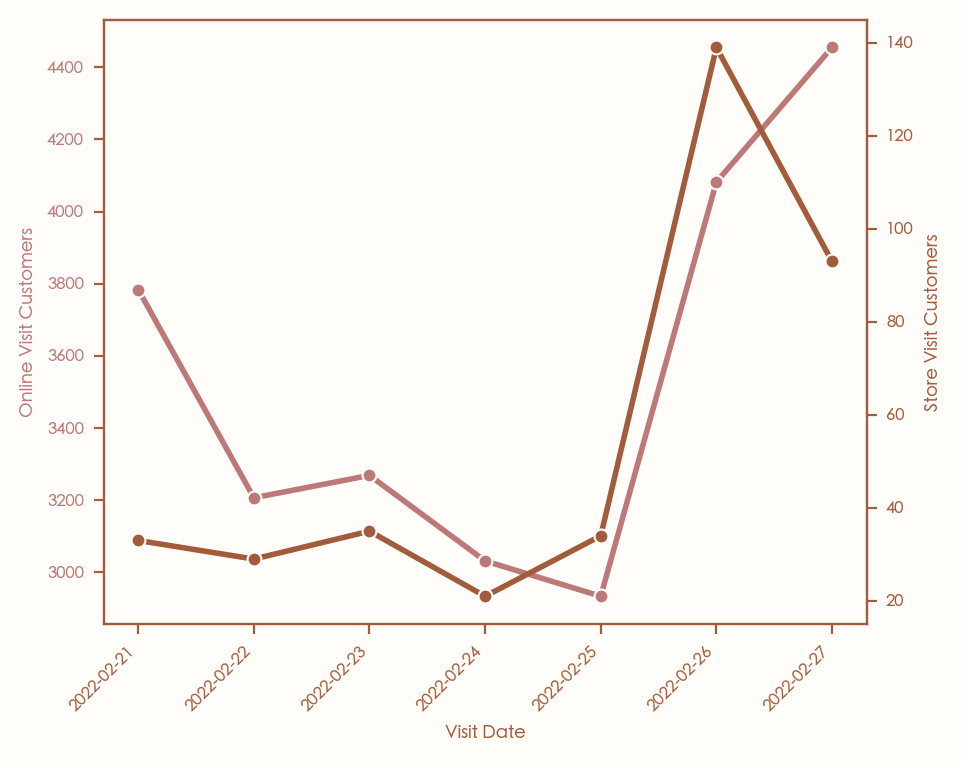

In [42]:
# define the default color for the visualizations
color = '#a35c3b'

# convert infinite values to NaN
aggr_combined_traffic_daily_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# set the graphics
plt.figure(figsize=(4.8, 3.8), dpi=200)  # adjust DPI for better resolution
plt.rcParams['font.family'] = 'Heiti TC'  # font to Heiti TC
plt.rcParams['font.size'] = 6.5  
plt.rcParams['axes.titlesize'] = 9  
plt.rcParams['axes.labelsize'] = 6.5  
plt.rcParams['text.color'] = color  
plt.rcParams['axes.labelcolor'] = color  
plt.rcParams['axes.edgecolor'] = color
plt.rcParams['axes.facecolor'] = '#FFFDF9'
plt.rcParams['xtick.color'] = color  
plt.rcParams['ytick.color'] = color  
plt.rcParams['figure.facecolor'] = '#FFFDF9' 
plt.rcParams['legend.facecolor'] = '#FFFDF9'  # Background color for the legend
plt.rcParams['legend.edgecolor'] = '#a35c3b'  # Edge color for the legend


# create the figure and axes
fig, ax1 = plt.subplots(figsize=(4.8, 3.8), dpi=200)

# create the first y-axis for web visitors
sns.lineplot(data=aggr_combined_traffic_daily_data, x='session_start_date', y='num_user_unique_w_page_visit', color='#BD7977', marker='o', markersize=5, linewidth=2, ax=ax1)
ax1.set_ylabel('Online Visit Customers', color='#BD7977')
ax1.tick_params(axis='y', labelcolor='#BD7977')

# create the second y-axis for store visitors
ax2 = ax1.twinx()
sns.lineplot(data=aggr_combined_traffic_daily_data, x='session_start_date', y='store_num_visitors', color='#a35c3b', marker='o', markersize=5, linewidth=2, ax=ax2)
ax2.set_ylabel('Store Visit Customers', color='#a35c3b')
ax2.tick_params(axis='y', labelcolor='#a35c3b')

# set the title and x-axis label
ax1.set_title('', fontweight='bold') # Daily Visitors: Online and Store'
ax1.set_xlabel('Visit Date')

# x-axis to display dates only (no time)
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.setp(ax1.get_xticklabels(), fontsize=6, rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), fontsize=6)
plt.setp(ax2.get_yticklabels(), fontsize=6)

# change the color of the spines to color
for spine in ax1.spines.values():
    spine.set_edgecolor(color)
for spine in ax2.spines.values():
    spine.set_edgecolor(color)

plt.tight_layout()
plt.show()

In [43]:
# online_data_per_known_user_session
# online_data_per_known_user_session[online_data_per_user_session['user_anonymity'] == 'Known']
# online_data_per_known_user_session.groupby(['session_start_day'])['user_session'].nunique().reset_index()

/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/3057199786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session['session_start_day'] = online_data_per_known_user_session['session_start_timestamp'].dt.date
/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/3057199786.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session['user_session'] = (


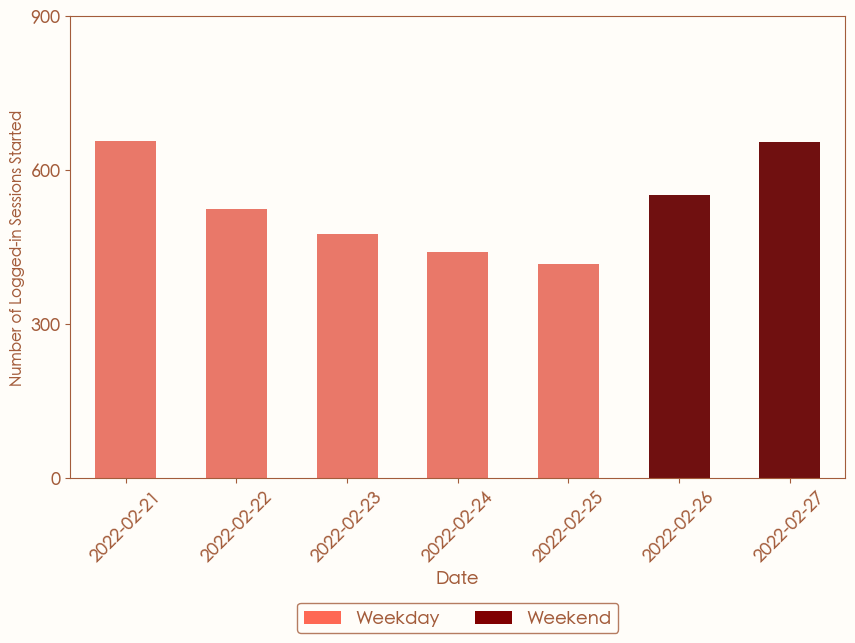

In [44]:
# let's look at the logged in sessions started by day

# include only "Known" users 
online_data_per_known_user_session = online_data_per_user_session[(online_data_per_user_session['user_anonymity'] == 'Known')]

# get the date when the session started
online_data_per_known_user_session['session_start_day'] = online_data_per_known_user_session['session_start_timestamp'].dt.date

# define a new column to uniquely identify user sessions
online_data_per_known_user_session['user_session'] = (
    online_data_per_known_user_session['user_id_key'].astype(str) + '_' + 
    online_data_per_known_user_session['session_id'].astype(str)
)

# counts of unique user sessions per day
session_counts_by_day = online_data_per_known_user_session.groupby(['session_start_day'])['user_session'].nunique().reset_index()

# rename columns
session_counts_by_day.rename(columns={'user_session': 'num_sessions'}, inplace=True)

# colors for the bars
def get_color(date):
    if date in ['2022-02-26', '2022-02-27']:
        return 'maroon'
    return '#fe6854'

custom_colors = [get_color(str(date)) for date in session_counts_by_day['session_start_day']]

plt.figure(figsize=(10, 6), dpi=100)

sns.barplot(
    x='session_start_day', 
    y='num_sessions', 
    data=session_counts_by_day,
    palette=custom_colors,
    width=0.55  
)

plt.xlabel('Date', fontsize=13)
plt.ylabel('Number of Logged-in Sessions Started', fontsize=11)

plt.xticks(rotation=45, fontsize=13)
y_max = 900
plt.ylim(0, y_max)
plt.yticks(range(0, y_max + 1, 300), fontsize=13)

# customize legends 
legend_labels = [Patch(facecolor='#fe6854', label='Weekday'), Patch(facecolor='maroon', label='Weekend')]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=13)

plt.show()


/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/2322231592.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  & (online_data_per_user_session['session_start_date'].isin(['2022-02-21', '2022-02-27']))]
/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/2322231592.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session_select['session_start_hour'] = online_data_per_known_user_session_select['session_start_timestamp'].dt.hour
/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel

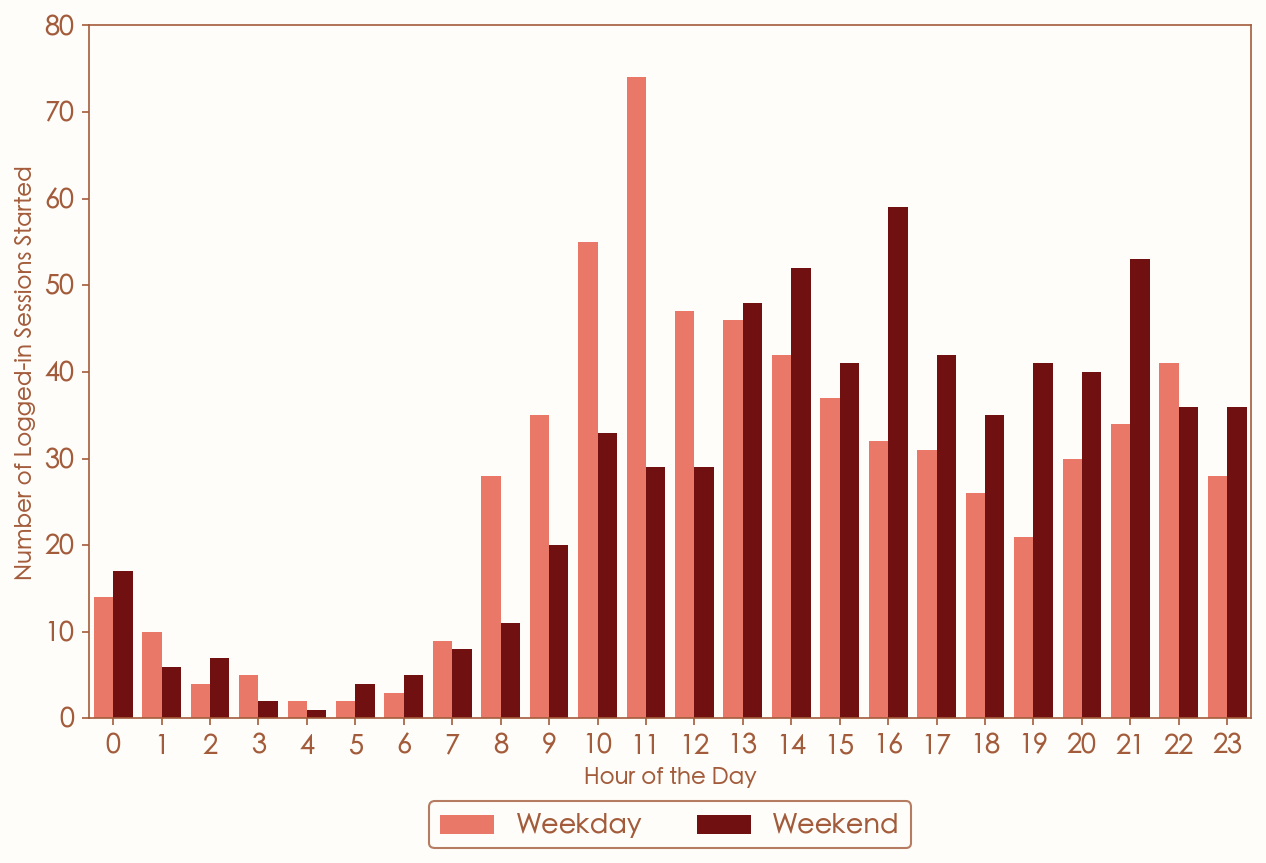

In [45]:
# let's look at the monday (21st) and sunday (27th) traffic by hour

# include "Known" users and two days above
online_data_per_known_user_session_select = online_data_per_user_session[(online_data_per_user_session['user_anonymity'] == 'Known') 
                                                                         & (online_data_per_user_session['session_start_date'].isin(['2022-02-21', '2022-02-27']))]

# get the hour of the day when the session started
online_data_per_known_user_session_select['session_start_hour'] = online_data_per_known_user_session_select['session_start_timestamp'].dt.hour

# define weekday and weekend
online_data_per_known_user_session_select['session_day_type'] = online_data_per_known_user_session_select['session_start_date'].between('2022-02-21', '2022-02-25').astype(str)
online_data_per_known_user_session_select['session_day_type'] = online_data_per_known_user_session_select['session_day_type'].replace({'True': 'Weekday', 'False': 'Weekend'})

# identify unique user sessions
online_data_per_known_user_session_select['user_session'] = online_data_per_known_user_session_select['user_id_key'].astype(str) + '_' + online_data_per_known_user_session_select['session_id'].astype(str)

# get the number of unique user sessions per hour, per day type
session_counts_by_hour = online_data_per_known_user_session_select.groupby(['session_start_hour', 'session_day_type'])['user_session'].nunique().reset_index()

session_counts_by_hour.rename(columns={'user_session': 'num_sessions'}, inplace=True)

# colors for the bars depending on wkd vs. wkn
custom_colors = {
    'Weekday': '#fe6854',
    'Weekend': 'maroon'
}

plt.figure(figsize=(10, 6), dpi=150)

sns.barplot(
    x='session_start_hour', 
    y='num_sessions', 
    hue='session_day_type', 
    data=session_counts_by_hour,
    palette=custom_colors
)

plt.xlabel('Hour of the Day', fontsize=11)
plt.ylabel('Number of Logged-in Sessions Started', fontsize=11)

plt.xticks(range(24), fontsize=13)
plt.yticks(fontsize=13)
y_max = 80
plt.ylim(0, y_max)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=13)

plt.show()


/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/1147423853.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session_select['session_start_hour_bucket'] = pd.cut(online_data_per_known_user_session_select['session_start_hour'], bins=bins, labels=labels, right=False)
/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/1147423853.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_counts_by_hour = online_data_per_known_user_session_select.groupby(['session_start_hour_bucket', 'session_day_type']

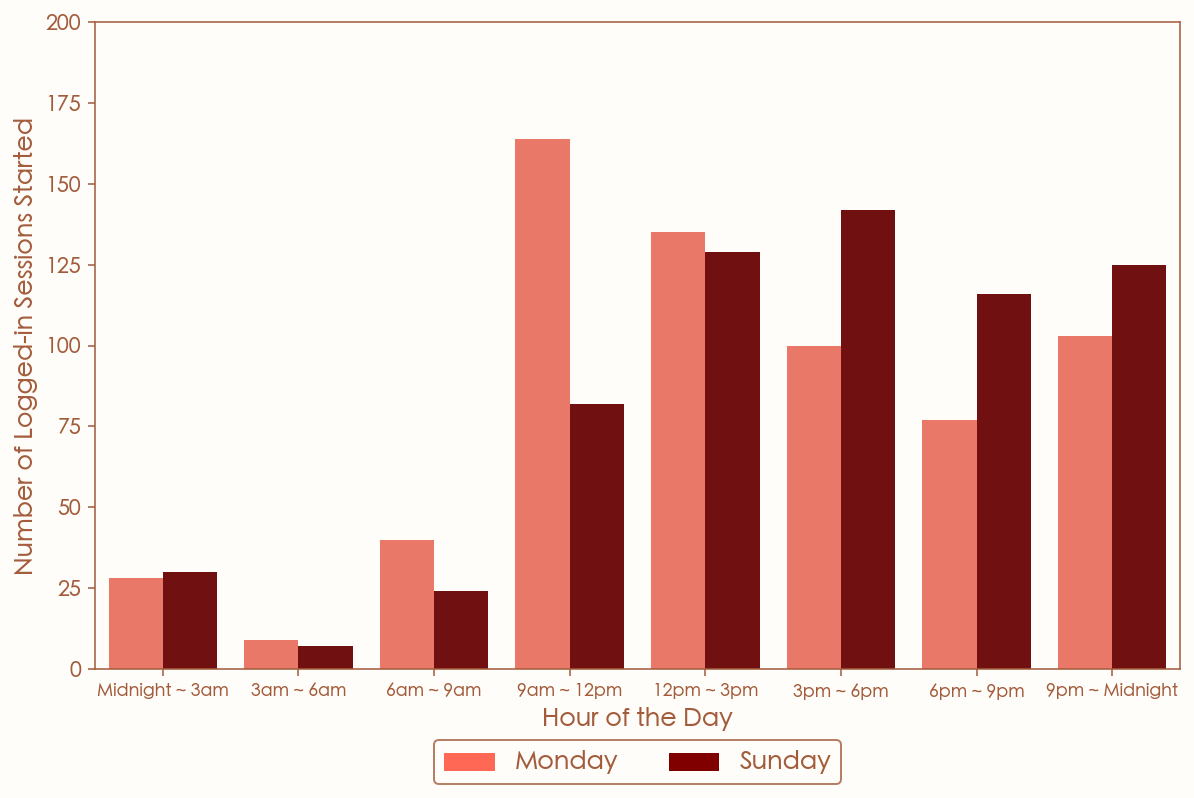

In [46]:
# let's look at it by 3 hour increments for easier look

# create a new column for 3-hour buckets
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24]
labels = ['Midnight ~ 3am', '3am ~ 6am', '6am ~ 9am','9am ~ 12pm', '12pm ~ 3pm', '3pm ~ 6pm', '6pm ~ 9pm', '9pm ~ Midnight']
online_data_per_known_user_session_select['session_start_hour_bucket'] = pd.cut(online_data_per_known_user_session_select['session_start_hour'], bins=bins, labels=labels, right=False)

# apply the new bins
session_counts_by_hour = online_data_per_known_user_session_select.groupby(['session_start_hour_bucket', 'session_day_type'])['user_session'].nunique().reset_index()

# renaming for clarity of the code
session_counts_by_hour.rename(columns={'user_session': 'num_sessions'}, inplace=True)

plt.figure(figsize=(10, 6), dpi=140)

sns.barplot(
    x='session_start_hour_bucket', 
    y='num_sessions', 
    hue='session_day_type', 
    data=session_counts_by_hour,
    palette=custom_colors
)

plt.xlabel('Hour of the Day', fontsize=13)
plt.ylabel('Number of Logged-in Sessions Started', fontsize=13)

plt.xticks(range(8), fontsize=9)
plt.yticks(fontsize=11)
y_max = 200
plt.ylim(0, y_max)

legend_labels = [Patch(facecolor='#fe6854', label='Monday'), Patch(facecolor='maroon', label='Sunday')]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=2, fontsize=13)

plt.show()


/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/546233018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session['session_start_hour'] = online_data_per_known_user_session['session_start_timestamp'].dt.hour
/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/546233018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session['session_start_hour_bucket'] = pd.cut(online_data_per_known_user_session['session_start_hour']

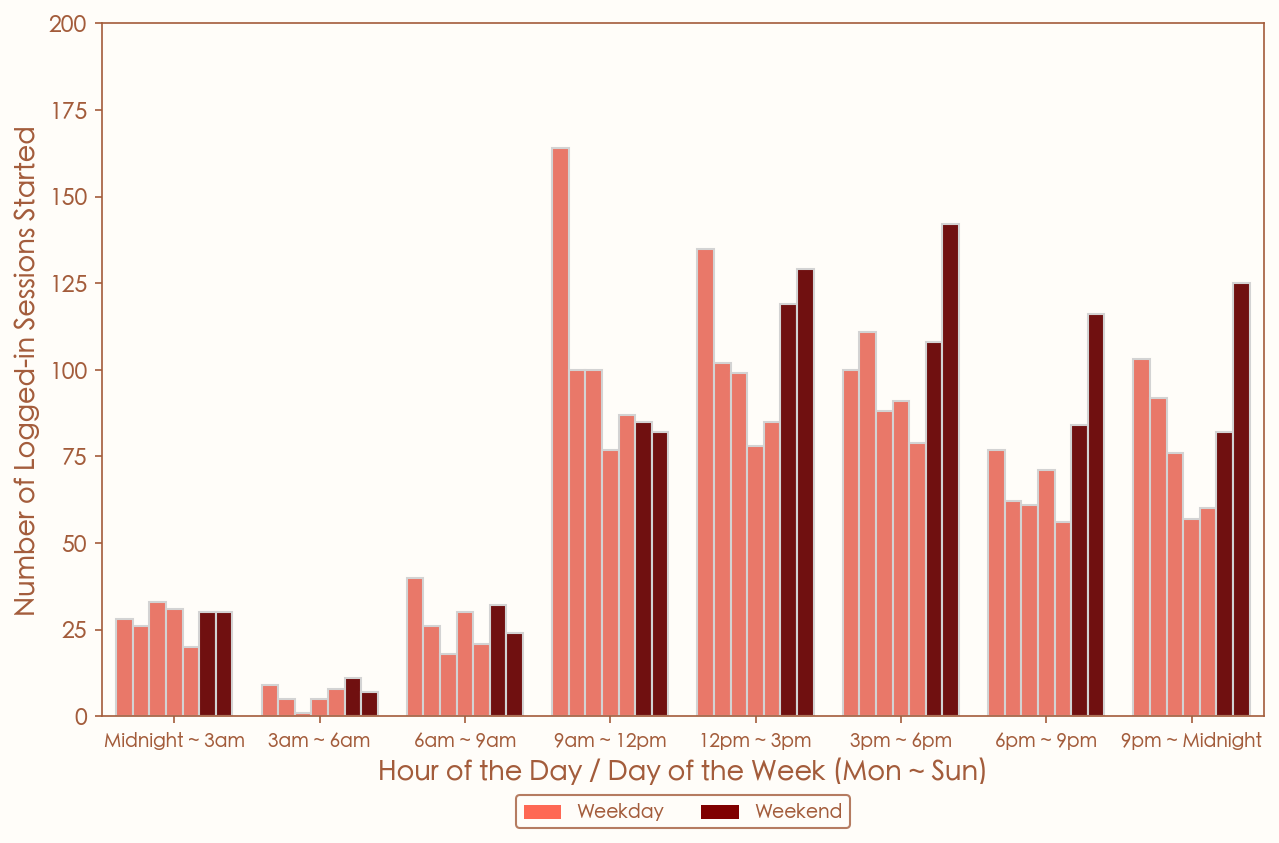

In [47]:
# for the record, let's have daily traffic by logged in users

# gete the hour of the day when the session started
online_data_per_known_user_session['session_start_hour'] = online_data_per_known_user_session['session_start_timestamp'].dt.hour

# a new column for 3-hour buckets
online_data_per_known_user_session['session_start_hour_bucket'] = pd.cut(online_data_per_known_user_session['session_start_hour'], bins=bins, labels=labels, right=False)

# get the number of unique user sessions per hour, per date
session_counts_by_hour = online_data_per_known_user_session.groupby(['session_start_hour_bucket', online_data_per_known_user_session['session_start_date'].dt.date])['user_session'].nunique().reset_index()

# renaming for tracking later
session_counts_by_hour.rename(columns={'user_session': 'num_sessions', 'session_start_date': 'date'}, inplace=True)

# convert the 'date' column to string for seaborn -- needed to debug using GPT
session_counts_by_hour['date'] = session_counts_by_hour['date'].astype(str)

# a palette dictionary to map dates to colors
palette = {date: get_color(date) for date in session_counts_by_hour['date'].unique()}


plt.figure(figsize=(10, 6), dpi=150)

sns.barplot(
    x='session_start_hour_bucket',
    y='num_sessions',
    hue='date',
    data=session_counts_by_hour,
    palette=palette,
    edgecolor="lightgray"  
)

plt.xlabel('Hour of the Day / Day of the Week (Mon ~ Sun)', fontsize=13)
plt.ylabel('Number of Logged-in Sessions Started', fontsize=13)

plt.xticks(fontsize=9)
plt.yticks(fontsize=11)
y_max = 200
plt.ylim(0, y_max)

legend_labels = [Patch(facecolor='#fe6854', label='Weekday'), Patch(facecolor='maroon', label='Weekend')]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize=9)

plt.show()


/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/2415125200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session_select2['session_start_hour'] = online_data_per_known_user_session_select2['session_start_timestamp'].dt.hour
/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/2415125200.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_data_per_known_user_session_select2['session_day_type'] = online_data_per_known_user_session_select2['

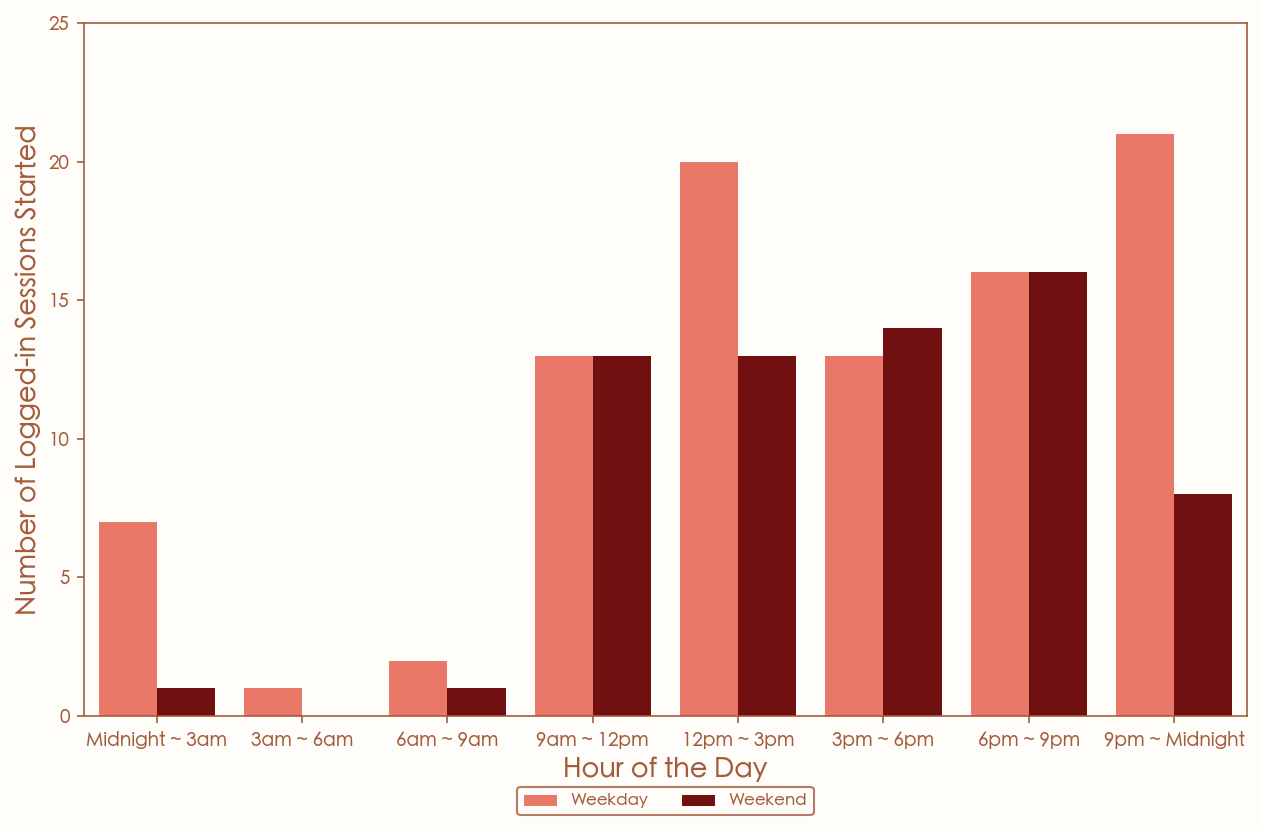

In [48]:
# let's look at the same view, but looking at sessions that ended up in a purchase

# "Known" users + online purchasors + sessions just on monday and sunday
online_data_per_known_user_session_select2 = online_data_per_user_session[(online_data_per_user_session['user_anonymity'] == 'Known') 
                                                                  & (online_data_per_user_session['num_online_purchase'] > 0)
                                                                #   & (online_data_per_user_session['session_start_date'].isin(['2022-02-21', '2022-02-27']))
                                                                  ]

# a lot of these things are iterative from the above code
online_data_per_known_user_session_select2['session_start_hour'] = online_data_per_known_user_session_select2['session_start_timestamp'].dt.hour

online_data_per_known_user_session_select2['session_day_type'] = online_data_per_known_user_session_select2['session_start_date'].between('2022-02-21', '2022-02-25').astype(str)
online_data_per_known_user_session_select2['session_day_type'] = online_data_per_known_user_session_select2['session_day_type'].replace({'True': 'Weekday', 'False': 'Weekend'})

online_data_per_known_user_session_select2['user_session'] = online_data_per_known_user_session_select2['user_id_key'].astype(str) + '_' + online_data_per_known_user_session_select2['session_id'].astype(str)

online_data_per_known_user_session_select2['session_start_hour_bucket'] = pd.cut(online_data_per_known_user_session_select2['session_start_hour'], bins=bins, labels=labels, right=False)

session_counts_by_hour = online_data_per_known_user_session_select2.groupby(['session_start_hour_bucket', 'session_day_type'])['user_session'].nunique().reset_index()

session_counts_by_hour.rename(columns={'user_session': 'num_sessions'}, inplace=True)

plt.figure(figsize=(10, 6), dpi=150)

sns.barplot(
    x='session_start_hour_bucket', 
    y='num_sessions', 
    hue='session_day_type', 
    data=session_counts_by_hour,
    palette=custom_colors
)

plt.xlabel('Hour of the Day', fontsize=13)
plt.ylabel('Number of Logged-in Sessions Started', fontsize=13)

plt.xticks(range(8), fontsize=9)
y_max = 25
plt.ylim(0, y_max)
plt.yticks(range(0, y_max + 1, 5), fontsize=9)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=2, fontsize=8, title_fontsize=8)

plt.show()


---
Revenue Analysis

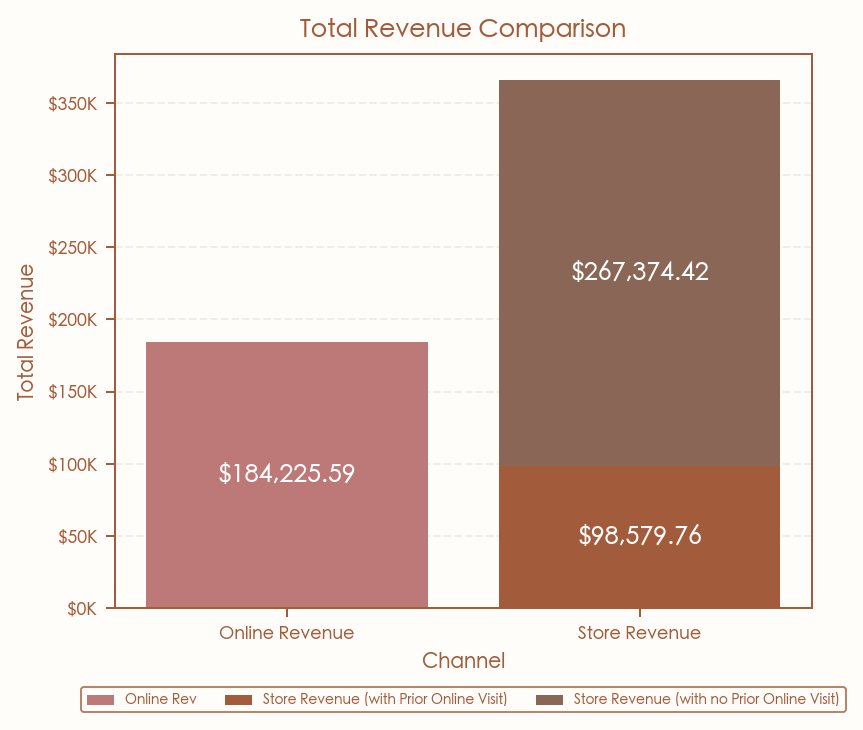

In [49]:
# calculate the portion of store revenue not attributed to prior online visits

total_store_revenue_non_attr_online = total_store_revenue - total_store_revenue_attr_online

labels = ['Online Revenue', 'Store Revenue']
online_values = [total_online_revenue, 0]
store_attr_online_values = [0, total_store_revenue_attr_online]
store_values = [0, total_store_revenue_non_attr_online]

plt.figure(figsize=(5, 4),dpi=180)
bars1 = plt.bar(labels, online_values, color='#BD7977', label='Online Revenue')
bars2 = plt.bar(labels, store_attr_online_values, color='#a35c3b', label='Store Revenue (Attributed to Online)')
bars3 = plt.bar(labels, store_values, color='#896655', bottom=store_attr_online_values, label='Store Revenue (Non-Attributed)')

plt.title('Total Revenue Comparison', fontsize=10)
plt.ylabel('Total Revenue', fontsize=8)
plt.xlabel('Channel', fontsize=8)

# gridlines behind the bars
plt.grid(axis='y', linestyle='--', alpha=0.2, zorder=0)
plt.gca().set_axisbelow(True)

# value labels inside the bars
def add_labels(bars, values):
    for bar, value in zip(bars, values):
        if value > 0:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_y() + yval/2, f'${value:,.2f}', fontsize=10, color='white', ha='center', va='center')

add_labels(bars1, online_values)
add_labels(bars2, store_attr_online_values)
add_labels(bars3, store_values)

# custom y-axis ticks to display in currency format
def currency_format(x, pos):
    if x >= 1e6:
        return '${:1.1f}M'.format(x*1e-6)
    return '${:1.0f}K'.format(x*1e-3)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(currency_format))

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# custom legends
legend_labels = [Patch(facecolor='#BD7977', label='Online Rev'), Patch(facecolor='#a35c3b', label='Store Revenue (with Prior Online Visit)'),Patch(facecolor='#896655', label='Store Revenue (with no Prior Online Visit)')]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3, fontsize=5.5, edgecolor='#a35c3b', frameon=True).get_frame().set_linewidth(0.75)

plt.show()

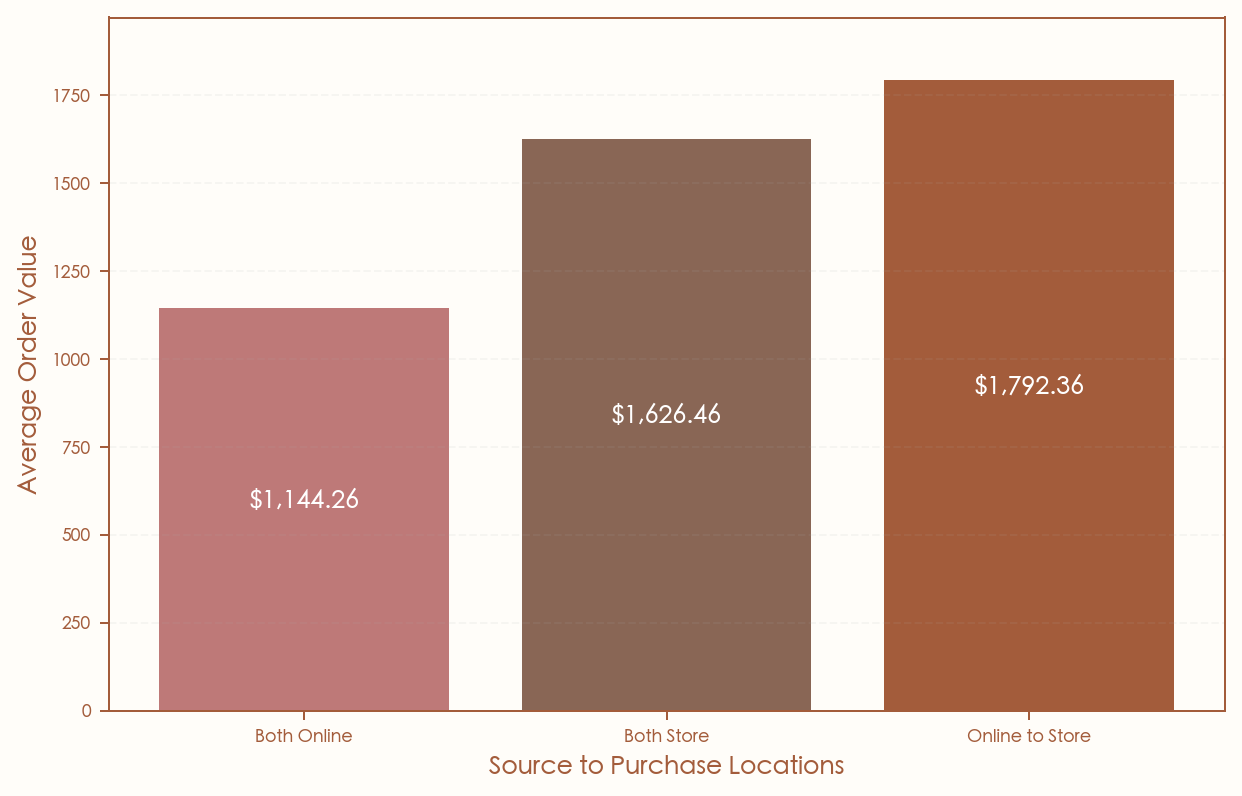

In [50]:
labels = ['Both Online','Both Store', 'Online to Store']
values = [round(total_online_revenue/total_online_purchase_trans,2), round(total_store_revenue/total_store_purchase_trans,2), round(total_store_revenue_attr_online/total_store_purchase_trans_attr_online,2)]

plt.figure(figsize=(8, 5), dpi=180)
bars = plt.bar(labels, values, color=['#BE7978','#896655', '#a35c3b'])

plt.ylabel('Average Order Value', fontsize=10)
plt.xlabel('Source to Purchase Locations', fontsize=10)

# custom gridlines
plt.grid(axis='y', linestyle='--', alpha=0.1, zorder=0)

# y-axis limit
max_y_value = max(values) * 1.1  # Customize this value as needed
plt.ylim(0, max_y_value)

# add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    label_position = yval - (yval * 0.5)
    plt.text(bar.get_x() + bar.get_width()/2, label_position, f'${yval:,.2f}', fontsize=10, fontweight='extra bold', color='white', ha='center')

# customize ticks
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

---
Item Analysis

In [51]:
item_dive_in_data.head(2)

,item_brand,item_id,users_w_purchase_total,users_w_online_purchase,users_w_store_purchase_total,users_w_store_attr_online_purchase,users_both_online_and_store_purchase,total_item_sales_rev,online_item_sales_rev,store_items_sales_rev,store_attr_online_items_sales_rev,total_quantity_sold,online_sold_units,store_sold_units,store_attr_online_sold_units,online_num_sessions_in_cart,online_num_sessions_in_checkout,online_num_sessions_purchased,cart_abandon_sessions,users_w_cart_abandons,checkout_abandon_sessions,users_w_checkout_abandons,avg_add_to_cart_sessions_before_online_purchase,avg_duration_first_add_to_cart_to_online_purchase,avg_begin_checkout_sessions_before_online_purchase,avg_duration_first_checkout_to_online_purchase,avg_add_to_cart_sessions_before_store_purchase_attr_online,avg_duration_first_add_to_cart_to_store_purchase_attr_online,avg_begin_checkout_sessions_before_store_purchase_attr_online,avg_duration_first_checkout_to_store_purchase_attr_online
0,Others,53900003,8.0,5.0,3.0,0.0,0.0,4459.10,2799.05,1660.05,0.0,8.0,5.0,3.0,0.0,7.0,9.0,5.0,7.0,6.0,9.0,6.0,1.2,10933.0,1.6,10426.2,0.0,0.0,0.0,0.0
1,AA,50440742-TR4003,4.0,0.0,4.0,0.0,0.0,3278.81,0.00,3278.81,0.0,4.0,0.0,4.0,0.0,3.0,4.0,0.0,3.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:

item_dive_in_data.columns.tolist()

['item_brand',
 'item_id',
 'users_w_purchase_total',
 'users_w_online_purchase',
 'users_w_store_purchase_total',
 'users_w_store_attr_online_purchase',
 'users_both_online_and_store_purchase',
 'total_item_sales_rev',
 'online_item_sales_rev',
 'store_items_sales_rev',
 'store_attr_online_items_sales_rev',
 'total_quantity_sold',
 'online_sold_units',
 'store_sold_units',
 'store_attr_online_sold_units',
 'online_num_sessions_in_cart',
 'online_num_sessions_in_checkout',
 'online_num_sessions_purchased',
 'cart_abandon_sessions',
 'users_w_cart_abandons',
 'checkout_abandon_sessions',
 'users_w_checkout_abandons',
 'avg_add_to_cart_sessions_before_online_purchase',
 'avg_duration_first_add_to_cart_to_online_purchase',
 'avg_begin_checkout_sessions_before_online_purchase',
 'avg_duration_first_checkout_to_online_purchase',
 'avg_add_to_cart_sessions_before_store_purchase_attr_online',
 'avg_duration_first_add_to_cart_to_store_purchase_attr_online',
 'avg_begin_checkout_sessions_before

In [53]:
# let's get some performance measurements on items

# create function to calculate ratio
def safe_divide(numerator, denominator):
    return numerator / denominator if denominator != 0 else np.nan

# grouping
grouped = item_dive_in_data.groupby('item_id').agg({
    'online_item_sales_rev': 'sum',
    'total_quantity_sold': 'sum',
    'online_sold_units': 'sum',
    'store_sold_units': 'sum',
    'store_attr_online_sold_units': 'sum',
    'cart_abandon_sessions': 'sum',
    'online_num_sessions_in_cart': 'sum',
    'online_num_sessions_in_checkout': 'sum',
    'checkout_abandon_sessions': 'sum',
    'online_num_sessions_purchased': 'sum',
    'users_w_cart_abandons': 'sum',
    'users_w_online_purchase': 'sum',
    'avg_add_to_cart_sessions_before_online_purchase': 'mean',
    'avg_duration_first_checkout_to_online_purchase': 'mean'
}).reset_index()

# calculation of the ratios
grouped['add_to_cart_to_cart_abandon_rate'] = grouped.apply(lambda row: round(safe_divide(row['cart_abandon_sessions'], row['online_num_sessions_in_cart']), 3), axis=1)
grouped['add_to_cart_to_checkout_success_rate'] = grouped.apply(lambda row: round(safe_divide(row['online_num_sessions_in_checkout'], row['online_num_sessions_in_cart']), 3), axis=1)
grouped['checkout_to_checkout_abandon_rate'] = grouped.apply(lambda row: round(safe_divide(row['checkout_abandon_sessions'], row['online_num_sessions_in_checkout']), 3), axis=1)
grouped['checkout_to_purchase_success_rate'] = grouped.apply(lambda row: round(safe_divide(row['online_num_sessions_purchased'], row['online_num_sessions_in_checkout']), 3), axis=1)
grouped['checkout_salvage_rate'] = grouped.apply(lambda row: round(safe_divide(row['online_num_sessions_purchased'], row['checkout_abandon_sessions']), 3), axis=1)

grouped['users_with_purchase_over_users_with_cart_abandon_ratio'] = grouped.apply(lambda row: round(safe_divide(row['users_w_cart_abandons'], row['users_w_online_purchase']), 3), axis=1)
grouped['users_with_purchase_over_users_with_checkout_abandon_ratio'] = grouped.apply(lambda row: round(safe_divide(row['users_w_cart_abandons'], row['users_w_online_purchase']), 3), axis=1)
grouped['average_add_to_cart_sessions_before_online_purchase'] = grouped['avg_add_to_cart_sessions_before_online_purchase'].round(3)
grouped['average_add_to_cart_to_online_purchase_duration'] = grouped['avg_duration_first_checkout_to_online_purchase'].round(3)

# numerator and denominator columns
grouped['online_item_sales_rev_sum'] = grouped['online_item_sales_rev']
grouped['total_quantity_sold_sum'] = grouped['total_quantity_sold']
grouped['online_sold_units_sum'] = grouped['online_sold_units']
grouped['store_sold_units_sum'] = grouped['store_sold_units']
grouped['store_attr_online_sold_units_sum'] = grouped['store_attr_online_sold_units']

grouped['cart_abandon_sessions_sum'] = grouped['cart_abandon_sessions']
grouped['online_num_sessions_in_cart_sum'] = grouped['online_num_sessions_in_cart']
grouped['online_num_sessions_in_checkout_sum'] = grouped['online_num_sessions_in_checkout']
grouped['checkout_abandon_sessions_sum'] = grouped['checkout_abandon_sessions']
grouped['online_num_sessions_purchased_sum'] = grouped['online_num_sessions_purchased']
grouped['users_w_cart_abandons_sum'] = grouped['users_w_cart_abandons']
grouped['users_w_online_purchase_sum'] = grouped['users_w_online_purchase']

# rename columns for easibility
grouped.rename(columns={
    'add_to_cart_to_cart_abandon_rate': 'Add to cart to cart abandon rate',
    'add_to_cart_to_checkout_success_rate': 'Add to cart to checkout success rate',
    'checkout_to_checkout_abandon_rate': 'Checkout to checkout abandon rate',
    'checkout_to_purchase_success_rate': 'Checkout to purchase success rate',
    'checkout_salvage_rate': 'Checkout salvage rate',
    
    'users_with_purchase_over_users_with_cart_abandon_ratio': 'Users with purchase over users with cart abandon ratio',
    'users_with_purchase_over_users_with_checkout_abandon_ratio': 'Users with purchase over users with checkout abandon ratio',
    'average_add_to_cart_sessions_before_online_purchase': 'Average of add to cart sessions before online purchase',
    'average_add_to_cart_to_online_purchase_duration': 'Average of add to cart to online purchase duration'
}, inplace=True)

result_columns = [
    'item_id',
    'total_quantity_sold_sum','online_item_sales_rev_sum',
    'online_sold_units_sum','store_sold_units_sum','store_attr_online_sold_units_sum',
    
    'Checkout salvage rate',
    'Checkout to purchase success rate',
    'online_num_sessions_purchased_sum',
    'Checkout to checkout abandon rate',
    'checkout_abandon_sessions_sum',
    'Add to cart to checkout success rate',
    'online_num_sessions_in_checkout_sum',
    'Add to cart to cart abandon rate', 
    'cart_abandon_sessions_sum',
    'online_num_sessions_in_cart_sum',
    
    'users_w_online_purchase_sum',
    'users_w_cart_abandons_sum',

    'Average of add to cart to online purchase duration',
    'Average of add to cart sessions before online purchase',
    'Users with purchase over users with checkout abandon ratio',
    'Users with purchase over users with cart abandon ratio'
]

result = grouped[result_columns]

result = result[result['online_item_sales_rev_sum']>0].sort_values('store_attr_online_sold_units_sum',ascending=False)
result[result['item_id'].isin(['52460052', '40550097'])]

,item_id,total_quantity_sold_sum,online_item_sales_rev_sum,online_sold_units_sum,store_sold_units_sum,store_attr_online_sold_units_sum,Checkout salvage rate,Checkout to purchase success rate,online_num_sessions_purchased_sum,Checkout to checkout abandon rate,checkout_abandon_sessions_sum,Add to cart to checkout success rate,online_num_sessions_in_checkout_sum,Add to cart to cart abandon rate,cart_abandon_sessions_sum,online_num_sessions_in_cart_sum,users_w_online_purchase_sum,users_w_cart_abandons_sum,Average of add to cart to online purchase duration,Average of add to cart sessions before online purchase,Users with purchase over users with checkout abandon ratio,Users with purchase over users with cart abandon ratio
73,40550097,14.0,4200.95,5.0,9.0,2.0,0.500,0.500,5.0,1.0,10.0,0.667,10.0,1.0,15.0,15.0,5.0,9.0,39625.600,1.5,1.800,1.800
231,52460052,13.0,4718.67,11.0,2.0,0.0,0.778,0.778,7.0,1.0,9.0,0.900,9.0,1.0,10.0,10.0,7.0,10.0,560.286,1.0,1.429,1.429


In [54]:
store_sales_details_df[(store_sales_details_df['item_id'].isin(['52460052', '40550097'])) & (store_sales_details_df['event_name'] == 'purchase')].sort_values(by=['item_id', 'event_timestamp_local'], ascending=[True, True])

,event_id,event_name,user_id,event_timestamp_GMT,event_timestamp_local,event_date_GMT,event_date_local,event_day_GMT,event_day_local,event_day_kind_GMT,event_day_kind_local,item_id,price,quantity
58,27,purchase,136045,2022-02-22 00:23:38,2022-02-22 08:23:38,2022-02-22,2022-02-22,Tue,Tue,Weekday,Weekday,40550097,846.06,1.0
121,63,purchase,136094,2022-02-23 00:08:03,2022-02-23 08:08:03,2022-02-23,2022-02-23,Wed,Wed,Weekday,Weekday,40550097,853.68,1.0
79,43,purchase,1488,2022-02-23 00:14:31,2022-02-23 08:14:31,2022-02-23,2022-02-23,Wed,Wed,Weekday,Weekday,40550097,849.00,1.0
97,50,purchase,136075,2022-02-23 00:49:38,2022-02-23 08:49:38,2022-02-23,2022-02-23,Wed,Wed,Weekday,Weekday,40550097,849.81,1.0
153,78,purchase,110049,2022-02-24 00:42:21,2022-02-24 08:42:21,2022-02-24,2022-02-24,Thu,Thu,Weekday,Weekday,40550097,849.00,1.0
168,83,purchase,135970,2022-02-24 00:47:50,2022-02-24 08:47:50,2022-02-24,2022-02-24,Thu,Thu,Weekday,Weekday,40550097,849.00,1.0
339,173,purchase,136247,2022-02-27 00:00:18,2022-02-27 08:00:18,2022-02-27,2022-02-27,Sun,Sun,Weekend,Weekend,40550097,842.84,1.0
361,185,purchase,136257,2022-02-27 00:41:41,2022-02-27 08:41:41,2022-02-27,2022-02-27,Sun,Sun,Weekend,Weekend,40550097,847.29,1.0
379,189,purchase,127765,2022-02-27 00:48:50,2022-02-27 08:48:50,2022-02-27,2022-02-27,Sun,Sun,Weekend,Weekend,40550097,805.06,1.0
197,97,purchase,136152,2022-02-25 00:40:57,2022-02-25 08:40:57,2022-02-25,2022-02-25,Fri,Fri,Weekday,Weekday,52460052,872.04,1.0


In [55]:
web_traffic_details_df[(web_traffic_details_df['item_id'].isin(['52460052', '40550097'])) & (web_traffic_details_df['event_name'] == 'purchase')].sort_values(by=['item_id', 'event_timestamp_local'], ascending=[True, True])

,session_id,event_name,user_id,user_pseudo_id,event_date_GMT,event_date_local,event_timestamp_GMT,event_timestamp_local,event_day_GMT,event_day_local,event_day_kind_GMT,event_day_kind_local,item_id,item_brand,price,quantity
6335,1645537721,purchase,136064,714457341.1642656346,2022-02-22,2022-02-22,2022-02-22 13:55:06,2022-02-22 21:55:06,Tue,Tue,Weekday,Weekday,40550097,E,840.19,1
13919,1645705863,purchase,135970,1403094849.1642661674,2022-02-24,2022-02-24,2022-02-24 12:47:50,2022-02-24 20:47:50,Thu,Thu,Weekday,Weekday,40550097,E,840.19,1
17494,1645862438,purchase,129087,884822809.1645862439,2022-02-26,2022-02-26,2022-02-26 08:03:43,2022-02-26 16:03:43,Sat,Sat,Weekend,Weekend,40550097,E,840.19,1
21157,1645963037,purchase,135972,1888248010.1633430800,2022-02-27,2022-02-27,2022-02-27 12:03:08,2022-02-27 20:03:08,Sun,Sun,Weekend,Weekend,40550097,E,840.19,1
21267,1645975732,purchase,135784,183207466.1645975734,2022-02-27,2022-02-27,2022-02-27 15:59:30,2022-02-27 23:59:30,Sun,Sun,Weekend,Weekend,40550097,E,840.19,1
399,1645423716,purchase,136008,190822050.1642670898,2022-02-21,2022-02-21,2022-02-21 06:16:01,2022-02-21 14:16:01,Mon,Mon,Weekday,Weekday,52460052,Others,428.97,2
2126,1645459648,purchase,136035,971376346.1645459648,2022-02-21,2022-02-22,2022-02-21 16:35:25,2022-02-22 00:35:25,Mon,Tue,Weekday,Weekday,52460052,Others,428.97,1
2326,1645492827,purchase,136039,121462469.1644636340,2022-02-22,2022-02-22,2022-02-22 01:50:27,2022-02-22 09:50:27,Tue,Tue,Weekday,Weekday,52460052,Others,428.97,2
14664,1645762021,purchase,136140,437777935.1645762021,2022-02-25,2022-02-25,2022-02-25 04:27:02,2022-02-25 12:27:02,Fri,Fri,Weekday,Weekday,52460052,Others,428.97,1
14684,1645764418,purchase,136142,19621925.1645021463,2022-02-25,2022-02-25,2022-02-25 05:53:02,2022-02-25 13:53:02,Fri,Fri,Weekday,Weekday,52460052,Others,428.97,2


In [56]:
# let's get some performance measurements on item brands

# create function to calculate ratio
def safe_divide(numerator, denominator):
    return numerator / denominator if denominator != 0 else np.nan

# grouping
grouped = item_dive_in_data.groupby('item_brand').agg({
    'online_item_sales_rev': 'sum',
    'total_quantity_sold': 'sum',
    'online_sold_units': 'sum',
    'store_sold_units': 'sum',
    'store_attr_online_sold_units': 'sum',
    'cart_abandon_sessions': 'sum',
    'online_num_sessions_in_cart': 'sum',
    'online_num_sessions_in_checkout': 'sum',
    'checkout_abandon_sessions': 'sum',
    'online_num_sessions_purchased': 'sum',
    'users_w_cart_abandons': 'sum',
    'users_w_online_purchase': 'sum',
    'avg_add_to_cart_sessions_before_online_purchase': 'mean',
    'avg_duration_first_checkout_to_online_purchase': 'mean'
}).reset_index()

# calculation of the ratios
grouped['add_to_cart_to_cart_abandon_rate'] = grouped.apply(lambda row: round(safe_divide(row['cart_abandon_sessions'], row['online_num_sessions_in_cart']), 3), axis=1)
grouped['add_to_cart_to_checkout_success_rate'] = grouped.apply(lambda row: round(safe_divide(row['online_num_sessions_in_checkout'], row['online_num_sessions_in_cart']), 3), axis=1)
grouped['checkout_to_checkout_abandon_rate'] = grouped.apply(lambda row: round(safe_divide(row['checkout_abandon_sessions'], row['online_num_sessions_in_checkout']), 3), axis=1)
grouped['checkout_to_purchase_success_rate'] = grouped.apply(lambda row: round(safe_divide(row['online_num_sessions_purchased'], row['online_num_sessions_in_checkout']), 3), axis=1)
grouped['checkout_salvage_rate'] = grouped.apply(lambda row: round(safe_divide(row['online_num_sessions_purchased'], row['checkout_abandon_sessions']), 3), axis=1)

grouped['users_with_purchase_over_users_with_cart_abandon_ratio'] = grouped.apply(lambda row: round(safe_divide(row['users_w_cart_abandons'], row['users_w_online_purchase']), 3), axis=1)
grouped['users_with_purchase_over_users_with_checkout_abandon_ratio'] = grouped.apply(lambda row: round(safe_divide(row['users_w_cart_abandons'], row['users_w_online_purchase']), 3), axis=1)
grouped['average_add_to_cart_sessions_before_online_purchase'] = grouped['avg_add_to_cart_sessions_before_online_purchase'].round(3)
grouped['average_add_to_cart_to_online_purchase_duration'] = grouped['avg_duration_first_checkout_to_online_purchase'].round(3)

# numerator and denominator columns
grouped['online_item_sales_rev_sum'] = grouped['online_item_sales_rev']
grouped['total_quantity_sold_sum'] = grouped['total_quantity_sold']
grouped['online_sold_units_sum'] = grouped['online_sold_units']
grouped['store_sold_units_sum'] = grouped['store_sold_units']
grouped['store_attr_online_sold_units_sum'] = grouped['store_attr_online_sold_units']

grouped['cart_abandon_sessions_sum'] = grouped['cart_abandon_sessions']
grouped['online_num_sessions_in_cart_sum'] = grouped['online_num_sessions_in_cart']
grouped['online_num_sessions_in_checkout_sum'] = grouped['online_num_sessions_in_checkout']
grouped['checkout_abandon_sessions_sum'] = grouped['checkout_abandon_sessions']
grouped['online_num_sessions_purchased_sum'] = grouped['online_num_sessions_purchased']
grouped['users_w_cart_abandons_sum'] = grouped['users_w_cart_abandons']
grouped['users_w_online_purchase_sum'] = grouped['users_w_online_purchase']

# rename columns for easibility
grouped.rename(columns={
    'add_to_cart_to_cart_abandon_rate': 'Add to cart to cart abandon rate',
    'add_to_cart_to_checkout_success_rate': 'Add to cart to checkout success rate',
    'checkout_to_checkout_abandon_rate': 'Checkout to checkout abandon rate',
    'checkout_to_purchase_success_rate': 'Checkout to purchase success rate',
    'checkout_salvage_rate': 'Checkout salvage rate',
    
    'users_with_purchase_over_users_with_cart_abandon_ratio': 'Users with purchase over users with cart abandon ratio',
    'users_with_purchase_over_users_with_checkout_abandon_ratio': 'Users with purchase over users with checkout abandon ratio',
    'average_add_to_cart_sessions_before_online_purchase': 'Average of add to cart sessions before online purchase',
    'average_add_to_cart_to_online_purchase_duration': 'Average of add to cart to online purchase duration'
}, inplace=True)

result_columns = [
    'item_brand',
    'total_quantity_sold_sum','online_item_sales_rev_sum',
    'online_sold_units_sum','store_sold_units_sum','store_attr_online_sold_units_sum',
    
    'Checkout salvage rate',
    'Checkout to purchase success rate',
    'online_num_sessions_purchased_sum',
    'Checkout to checkout abandon rate',
    'checkout_abandon_sessions_sum',
    'Add to cart to checkout success rate',
    'online_num_sessions_in_checkout_sum',
    'Add to cart to cart abandon rate', 
    'cart_abandon_sessions_sum',
    'online_num_sessions_in_cart_sum',
    
    'users_w_online_purchase_sum',
    'users_w_cart_abandons_sum',

    'Average of add to cart to online purchase duration',
    'Average of add to cart sessions before online purchase',
    'Users with purchase over users with checkout abandon ratio',
    'Users with purchase over users with cart abandon ratio'
]

result = grouped[result_columns]

result = result[result['online_item_sales_rev_sum']>0].sort_values('store_attr_online_sold_units_sum',ascending=False)
result.head(2)

,item_brand,total_quantity_sold_sum,online_item_sales_rev_sum,online_sold_units_sum,store_sold_units_sum,store_attr_online_sold_units_sum,Checkout salvage rate,Checkout to purchase success rate,online_num_sessions_purchased_sum,Checkout to checkout abandon rate,checkout_abandon_sessions_sum,Add to cart to checkout success rate,online_num_sessions_in_checkout_sum,Add to cart to cart abandon rate,cart_abandon_sessions_sum,online_num_sessions_in_cart_sum,users_w_online_purchase_sum,users_w_cart_abandons_sum,Average of add to cart to online purchase duration,Average of add to cart sessions before online purchase,Users with purchase over users with checkout abandon ratio,Users with purchase over users with cart abandon ratio
26,E,82.0,20577.579999,32.0,50.0,3.0,0.410,0.410,25.0,1.0,61.0,0.575,61.0,1.0,106.0,106.0,25.0,92.0,8335.280,0.652,3.680,3.680
31,Others,193.0,45208.460000,96.0,97.0,2.0,0.577,0.577,75.0,1.0,130.0,0.546,130.0,1.0,238.0,238.0,75.0,233.0,8342.046,0.472,3.107,3.107


## Future Projects

Analysis findings summarized to make recommendations on future projects

In [57]:
# the proof that session_id's can have multiple user_id's and user_pseudo_id's

# this number was a lot worse before weeding the sessions with 0 seconds and sessions belonging to the 48 user_pseudo_id's
web_traffic_details_df.groupby('session_id')['user_id'].nunique().sort_values(ascending=False)

# session id = '1645223800' has 14 user_pseudo_id's

# 	    session_id	user_pseudo_id
# 0	    1645223800	996865367.1645225
# 1	    1645223800	867956511.1645224
# 2	    1645223800	80633495.16452238
# 3	    1645223800	791021319.1645224
# 4	    1645223800	56725126.16452239
# 5	    1645223800	300923985.1645224
# 6	    1645223800	2081561954.1645224
# 7	    1645223800	1884943816.1645224
# 8	    1645223800	1882908739.1645224
# 9	    1645223800	1849123043.1645224
# 10	1645223800	184893498.1645224
# 11	1645223800	1540262176.1645224
# 12	1645223800	1193605451.1645224
# 13	1645223800	1002757889.1645224

session_id
1645782170    2
1645585800    2
1645592660    2
1645687222    2
1645961675    2
             ..
1645598967    1
1645597988    1
1645597009    1
1645595493    1
1645975755    1
Name: user_id, Length: 579, dtype: int64

In [58]:
# anomalies: store purchase events only recorded between one hour of every day

print(store_sales_details_df['event_timestamp_local'].dt.hour.max() == store_sales_details_df['event_timestamp_local'].dt.hour.min())
print(store_sales_details_df['event_timestamp_local'].min())
print(store_sales_details_df['event_timestamp_local'].max())


True
2022-02-21 08:00:26
2022-02-27 08:59:29


In [59]:
# potential opportunity for loss prevention

web_traffic_details_df[web_traffic_details_df['item_id'] == '40550133'][web_traffic_details_df['event_name'] == 'purchase']
store_sales_details_df[store_sales_details_df['item_id'] == '40550133'][store_sales_details_df['event_name'] == 'purchase'].sort_values(by='event_timestamp_local', ascending=True)

/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/139276691.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  web_traffic_details_df[web_traffic_details_df['item_id'] == '40550133'][web_traffic_details_df['event_name'] == 'purchase']
/var/folders/j4/xjgsdpy56ldfy9xr7y963bzh0000gn/T/ipykernel_37626/139276691.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  store_sales_details_df[store_sales_details_df['item_id'] == '40550133'][store_sales_details_df['event_name'] == 'purchase'].sort_values(by='event_timestamp_local', ascending=True)


,event_id,event_name,user_id,event_timestamp_GMT,event_timestamp_local,event_date_GMT,event_date_local,event_day_GMT,event_day_local,event_day_kind_GMT,event_day_kind_local,item_id,price,quantity
8,4,purchase,110906,2022-02-21 00:58:26,2022-02-21 08:58:26,2022-02-21,2022-02-21,Mon,Mon,Weekday,Weekday,40550133,378.56,1.0
10,4,purchase,110906,2022-02-21 00:58:26,2022-02-21 08:58:26,2022-02-21,2022-02-21,Mon,Mon,Weekday,Weekday,40550133,399.97,1.0
140,71,purchase,135092,2022-02-24 00:30:27,2022-02-24 08:30:27,2022-02-24,2022-02-24,Thu,Thu,Weekday,Weekday,40550133,395.01,1.0
262,130,purchase,136192,2022-02-26 00:38:38,2022-02-26 08:38:38,2022-02-26,2022-02-26,Sat,Sat,Weekend,Weekend,40550133,758.00,1.0
445,222,purchase,135466,2022-02-27 00:40:24,2022-02-27 08:40:24,2022-02-27,2022-02-27,Sun,Sun,Weekend,Weekend,40550133,375.84,1.0
447,222,purchase,135466,2022-02-27 00:40:24,2022-02-27 08:40:24,2022-02-27,2022-02-27,Sun,Sun,Weekend,Weekend,40550133,396.50,1.0
360,185,purchase,136257,2022-02-27 00:41:41,2022-02-27 08:41:41,2022-02-27,2022-02-27,Sun,Sun,Weekend,Weekend,40550133,770.45,1.0


---
Archived analysis exploration

In [60]:
# Curious about the average online sessions needed to purchase online vs. purchase store attributed to online

# # the average sessions for online purchases
# total_online_sessions = online_data_per_user_session[online_data_per_user_session['first_online_purchase_timestamp'].notnull()]['session_order_rank'].sum()
# avg_sessions_online_purchase = total_online_sessions / total_online_purchase_trans

# # the average sessions for store purchases attributed to prior online activities
# online_sessions_for_store_purchases_attr_online = online_data_per_user_session[online_data_per_user_session['num_user_w_store_purchase'].notnull()]['session_order_rank'].sum()
# avg_sessions_store_purchase_attr_online = online_sessions_for_store_purchases_attr_online / total_store_purchase_trans_attr_online

# # Data
# purchase_types = ['Online Purchase', 'Store Purchase Attributed to Online']
# average_sessions = [avg_sessions_online_purchase, avg_sessions_store_purchase_attr_online]


# plt.figure(figsize=(12, 8), dpi=100)
# sns.barplot(x=purchase_types, y=average_sessions, palette=['skyblue', 'salmon'])

# plt.title('Average Sessions Needed to Complete Purchase', fontsize=16)
# plt.xlabel('Purchase Type', fontsize=14)
# plt.ylabel('Average Number of Sessions', fontsize=14)

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# for i, v in enumerate(average_sessions):
#     plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=12, color='black')

# plt.show()

# # Online Purchase - 3.39 average sessions needed to complete purchase vs. 
# # Store Purchase attributed to Online - 5.47

# abandon

---
Archived Notes

In [61]:
# archived at the end -- navigating data through python script rather than SQL via duckdb
# opted for SQL via duckdb instead of python for familiarity

# #web_events_details_df.head(10)
# web_events_details_df['event_name'].unique()
# #web_events_details_df[web_events_details_df['user_pseudo_id'] == '183207466.16459757']
# web_events_details_df[web_events_details_df['session_id'] == '1645975732'].tail(50)

# showroom_sales_details_df['event_date'] = showroom_sales_details_df['event_date_timestamp_local'].dt.date

# # Calculate 'total_sales' as the product of 'price' and 'quantity' for each transaction
# showroom_sales_details_df['total_sales'] = showroom_sales_details_df['price'] * showroom_sales_details_df['quantity']

# # Group by both 'event_date' and 'event_day_kind_local'
# daily_sales = showroom_sales_details_df.groupby(['event_date', 'event_day_kind_local']).agg(
#     daily_total_sales=('total_sales', 'sum'),
#     daily_total_quantity=('quantity', 'sum')
# ).reset_index()

# # Now group by 'event_day_kind_local' and calculate the average by the count of unique days in each category
# average_sales_and_quantity = daily_sales.groupby('event_day_kind_local').agg(
#     average_sales=('daily_total_sales', lambda x: x.sum() / x.count()),  # Sum sales and divide by the number of unique days
#     average_quantity=('daily_total_quantity', lambda x: x.sum() / x.count())  # Sum quantities and divide by the number of unique days
# ).reset_index()

# # daily sales and quantity
# print(daily_sales)
# # average sales and quantity per day for weekday vs. weekend
# print(average_sales_and_quantity)

In [62]:
# import matplotlib.font_manager
# from IPython.core.display import HTML

# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>Key Performance</span></p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))
